<img src="https://wallpaperaccess.com/full/6995640.jpg" alt="By Order of Peaky Blinders" style="background-size: cover;background-repeat: no-repeat; background-position: 50% 50%;width: 100%;height: 400px;" >

Website: https://peackyblinders.sarlove.com/

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
import urllib.request
import json
import os
import cv2
import community.community_louvain
import operator
from collections import Counter
from IPython.display import display_html
import glob
import sys

import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.text import TextCollection
import string
from matplotlib import cm
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

<h1 style="color:#42362B;"><b> Part 1: Motivation </b></h1>

<p style="color:#42362B;"> <b>1a. What is your dataset? Why did you choose this/these particular dataset(s)? </b></p>
<br>
<br>
<p style="color:#675544;">We decided to analyse the social interactions of Peaky Blinders, because we like the complex and interesting relationships between the characters in the show. The data we’ll be using will come from the Peaky Blinders <a href="https://peaky-blinders.fandom.com/wiki/Peaky_Blinders_Wiki">fandom wiki</a> and the subtitles from the show. </p>


 

<p style="color:#42362B;"> <b>1b. What was your goal for the end user's experience? </b></p>

<p style="color:#675544;">Our idea is to create a growing/evolving network, where nodes that represent characters are added to the network when they first appear and removed when they’re last seen in the show. </p>
<br>
<ul style="color:#675544;">
    <li>The links between nodes will then represents their relationship.</li>
<br>
<li>The nodes attributes will be allegiances and family as well has how much that appear in the show. The links attributes will contain the type of relationship.</li>
<br>
<li>We can then use this network to analyse the characters and their relationships throughout the show, using centrality measures and community detection.</li>
<br>
<li><ul>
With sentiment analysis we’ll achieve two goals.
    <br>
    <li>By analysing the subtitles we’ll see the evolution of tone throughout the series.</li>
    <li>By analysing the wiki texts the evolution of the characters.</li>
    </ul></li>
</ul>

<img src="https://cdn.pixabay.com/photo/2018/02/19/20/28/abstract-3166168__340.png" alt="devider" style=" width: 50%;" >

<h1 style="color:#42362B;"><b> Part 2: Basic stats. Let's understand the dataset better </h1></p>

<p style="color:#42362B;"> <b>2a. Write about your choices in data cleaning and preprocessing</b></p>


We decided to extract the some of the biographical information the full relationships and appearance information from the side infobox which every character page has, and use this information for the character traits.
From the main wiki text, we extracted all subsection from the "character history" and relationships sections. We also extracted all the quotes from the quotes section.

<p style="color:#42362B;"> <b>2b. Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)</b></p>

The wiki has 282 page and with the 30 hours of subtitles this totals 2Mb of raw text data.
The full network consists of 98 characters and 531 links. The average in-degree and out-degree is 5.85, the maximum in-degree and out-degree is 73 and 43 respectively, and the minimum in-degree and out-degree is 0.</p>

<img src="https://cdn.pixabay.com/photo/2018/02/19/20/28/abstract-3166168__340.png" alt="devider" style=" width: 50%;" > 

<h1 style="color:#42362B;"><b> Part 3: Tools, theory and analysis. Describe the process of theory to insight </b></h1>

<h2 style="color:#42362B;"><b> Data Acquisition</b></h2>

In [2]:
def get_page(title="Category:Characters"):
    ''' 
    Queries the peaky blinders fandom website for the page of the specified character.

    Parameters
    ----------
    title : str
        A string with the name of the desired character e.g. 'Thomas Shelby'
    '''
    baseurl = "https://peaky-blinders.fandom.com/api.php?"
    action = "action=query"
    title = "titles="+urllib.parse.quote_plus(title)
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"

    query= "{}{}&{}&{}&{}".format(baseurl, action, title, content, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    json_file = json.loads(wikitext)
    return json_file['query']['pages'][list(json_file['query']['pages'].keys())[0]]['revisions'][0]['slots']['main']['*']

In [3]:
# Reads the character names from the characters.txt file into a list 
with open("characters.txt","r") as chars:
    characters = chars.readlines()
characters = [name.strip() for name in characters]


def create_character_files(characters):
    '''
    Creates a text files for each character given, with the text from the wiki query.
    
    Parameters
    ----------
    characters : list
        A list of strings with the names of characters
    '''
    for name in characters:
        name = name.replace(" ","_")
        text = get_page(name)
        with open('raw_text/{}.txt'.format(name),'w') as file:
            file.write(text)
# create_character_files(characters)

In [4]:
def extract_match(match):
    '''
    A helper function which takes a regular expression search match and cleans it, by removing square and curly brackets and unnecessary text i.e. '(deceased)'.
    
    Parameters
    ----------
    match : match object
        A match object resulting from a regular expression search
    '''
    if match:
        temp = match.groups()[0]
        if '<br>' in temp:
            temp = re.findall(r'\[\[(.*?)\]\]',temp)
        elif type(temp) == str:
            temp = temp.replace('[','').replace(']','').replace('}','').replace('(deceased)','')
            if temp == "":
                return None
            elif temp[-1] == " ":
                temp = temp[:-1]
            temp = [temp]
        return temp
    else:
        return None

def get_character_traits(page,chars):
    '''
    Creates a dictionary with information from the character page given, on who is family and which other connections they have,
    their allegiance, if they are dead or alive, which series they are in, when they are first and last seen, how many episodes in total they are in,
    and if they are enemies or allies of the peaky blinders.
    
    Parameters
    ----------
    page : str
        A string containing the text from a character page
    chars : list
        The list of characters in the show
    '''
    trait_dict = {"family":"","other_relationships":"","allegiance":"", "status":"Alive", "series":"", "first_seen":"", "last_seen":"","appeared_in":0,"allies":False,"enemies":False}
    
    aka =  {'Polly Gray':'Polly Shelby','Ada Thorne':'Ada Shelby','Lizzie Stark':'Lizzie Shelby'}
    
    fam_terms = ['Wife|wife','Spouse|spouse','Husband|husband','Fiancé|fiancé',
                 'Father|father','Mother|mother','Brothers|brothers','Sisters|sisters',
                 'Sons|sons','Daughters|daughters','Nephews|nephews','Nieces|nieces',
                 'Great-nephews|great-nephews','Great-nieces|great-nieces',
                 'First_cousins|first_cousins','Aunts|aunts','Uncles|uncles',
                 'Grandmothers|grandmothers','Other_relatives|other_relatives',
                 'Children|children','Siblings|siblings','Parents|parents']
    
    fam = []
    for fam_term in fam_terms:
        pattern ="\|\s*(?:"+fam_term+")\s*=\s*(.*?)(?:\||\n|})"
        match = re.search(pattern,page)
        temp = extract_match(match)
        if temp is not None:
            fam.extend(temp)
    fam2 = []
    for char in chars:
        for name in fam:
            if char in list(aka.keys()):
                if re.search(r'{}|{}'.format(char,aka[char]),name):
                    fam2.append(char)
            else:
                if re.search(char,name):
                    fam2.append(char)
    trait_dict['family'] = list(set(fam2))
    
    
    rel_terms = fam_terms.copy()
    rel_terms.append('Romances|romances')
    for rel_term in rel_terms:
        pattern ="\|\s*(?:"+rel_term+")\s*=\s*(.*?)(?:\||\n|})"
        match = re.search(pattern,page)
        temp = extract_match(match)
        if temp is not None:
            if 'Arthur Shelby Sr.' in temp:
                chars.remove('Arthur Shelby')
            rel = []
            for char in chars:
                for name in temp:
                    if char in list(aka.keys()):
                        if re.search(r'{}|{}'.format(char,aka[char]),name):
                            rel.append(char)
                    else:
                        if re.search(char,name):
                            rel.append(char)
            if 'Arthur Shelby Sr.' in temp:
                chars.append('Arthur Shelby')
            if len(rel) != 0:
                trait_dict[rel_term[:rel_term.find('|')]] = rel
    
    
    match = re.findall(r"\[\[(.*?)(?:(?:\||#).*?)?\]\]",page)
    names = [name for name in match if name in chars]
    names = [name for name in names if name not in fam2]
    trait_dict['other_relationships'] = list(set(names))
    

    match = re.search(r"\|\s*(?:Allegiance|allegiance)\s*=\s*(.*?)(?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        if '<br>' in temp:
            temp2 = re.findall(r'\[\[(.*?)\]\]',temp)
            if temp2 == []:
                temp = temp.split("<br>")
            else:
                temp = temp2
        elif temp.count("[") > 2:
            temp = re.findall(r'\[\[(.*?)\]\]',temp)
        else:
            temp = temp.split(",")
            temp = [i.replace('[','').replace(']','') for i in temp if i != ""]
            for i,item in enumerate(temp):
                if item[-1] == " ":
                    item = item[:-1]
                if item[0] == " ":
                    item = item[1:]
                temp[i] = item
            
        trait_dict['allegiance'] = temp
        
        
    match = re.search(r"\|\s*(?:Status|status)\s*=\s*(.*?)(?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        if "Deceased" in temp:
            trait_dict['status'] = "Deceased"
        elif "Alive" in temp:
            trait_dict['status'] = "Alive"
    
    
    match = re.search(r"\|\s*(?:Series|series)\s*=\s*(.*?)\](?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        temp = re.findall(r'\[\[(.*?)\]',temp)
        trait_dict['series'] = temp
        
        
    match = re.search(r"\|\s*(?:First|first_seen)\s*=\s*(.*?)(?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        trait_dict['first_seen'] = temp.replace('[','').replace(']','')
        
        
    match = re.search(r"\|\s*(?:Last|last_seen)\s*=\s*(.*?)(?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        trait_dict['last_seen'] = temp.replace('[','').replace(']','')
        
        
    match = re.search(r"\|\s*(?:appeared_in|Appearances)\s*=\s*(.*?)(?:\||\n|})",page)
    if match:
        temp = match.groups()[0]
        try:
            temp = [int(s) for s in temp.split() if s.isdigit()][0]
        except:
            temp = 0
        trait_dict['appeared_in'] = temp
        
    return trait_dict

def get_traits(characters):
    '''
    Creates a dictionary with an entry for each character given with the information for that character from 'get_character_traits'.
    
    Parameters
    ----------
    characters : List
        A list of characters
    '''
    files = os.listdir("raw_text")
    if ".ipynb" in files[0]:
        files = files[1:]
    traits = {}
    for file in files:
        with open("raw_text/{}".format(file),'r') as f:
            text = f.read()
            traits[file[:-4].replace("_"," ")] = get_character_traits(text,characters)
    return traits

In [5]:
traits = get_traits(characters)
# Manually fixing/adding some missing data, which either was reported in a weird format or needed context to know.
traits['Al Capone']['first_seen'] = 'Episode 4.1'
traits['Al Capone']['last_seen'] = 'Episode 4.6'
traits['Anna Gray']['first_seen'] = 'Episode 1.6'
traits['Anna Gray']['last_seen'] = 'Episode 4.2'
traits['Birdie Boswell']['first_seen'] = 'Episode 3.2'
traits['Birdie Boswell']['last_seen'] = 'Episode 3.2'
traits['Esmeralda Gold']['first_seen'] = 'Episode 4.2'
traits['Esmeralda Gold']['last_seen'] = 'Episode 4.2'
traits['Kitty Jurossi']['first_seen'] = 'Episode 4.3'
traits['Kitty Jurossi']['last_seen'] = 'Episode 4.3'
traits['Martha Shelby']['first_seen'] = 'Episode 1.4'
traits['Martha Shelby']['last_seen'] = 'Episode 1.4'
traits['Rosemary Johnson']['last_seen'] = 'Episode 4.3'

traits['Ada Thorne']['allegiance'] = ['Shelby Family','Communists']
traits['Freddie Thorne']['allegiance'] = ['Shelby Family','Communists']
traits['Stanley Chapman']['allegiance'] = ['Communists']
traits['Greta Jurossi']['allegiance'] = ['Communists']
traits['Donal Henry']['allegiance'] = ['Irish Republican Army']
traits['Irene O’Donnell']['allegiance'] = ['Irish Republican Army','Major Campbell']

traits['Alfie Solomons']['enemies'] = True
traits['Angel Changretta']['enemies'] = True
traits['Anton Kaledin']['enemies'] = True
traits['Antonio']['enemies'] = True
traits['Audrey Changretta']['enemies'] = True
traits['Billy Kimber']['enemies'] = True
traits['Darby Sabini']['enemies'] = True
traits['Donal Henry']['enemies'] = True
traits['Maguire']['enemies'] = True
traits['Malacki Byrne']['enemies'] = True
traits['Mario']['enemies'] = True
traits['Matteo']['enemies'] = True
traits['Ollie']['enemies'] = True
traits['Patrick Jarvis']['enemies'] = True
traits['Roberts']['enemies'] = True
traits['Ryan']['enemies'] = True
traits['Sergeant Moss']['enemies'] = True
traits['Father Hughes']['enemies'] = True
traits['Frederico']['enemies'] = True
traits['Georgie Sewell']['enemies'] = True
traits['Henry Russell']['enemies'] = True
traits['Tatiana Petrovna']['enemies'] = True
traits['Inspector Campbell']['enemies'] = True
traits['Irene O’Donnell']['enemies'] = True
traits['Izabella Petrovna']['enemies'] = True
traits['Vicente Changretta']['enemies'] = True
traits['Jimmy McCavern']['enemies'] = True
traits['Winston Churchill']['enemies'] = True
traits['Leon Petrovich Romanov']['enemies'] = True
traits['Luca Changretta']['enemies'] = True


traits['Alfie Solomons']['allies'] = True
traits['Al Capone']['allies'] = True
traits['Aberama Gold']['allies'] = True
traits['Arthur Bigge']['allies'] = True
traits['James']['allies'] = True
traits['Jeremiah Jesus']['allies'] = True
traits['Jessie Eden']['allies'] = True
traits['Johnny Dogs']['allies'] = True
traits['King Maine']['allies'] = True
traits['Ben Younger']['allies'] = True
traits['Billy Kitchen']['allies'] = True
traits['Billy Mills']['allies'] = True
traits['Bonnie Gold']['allies'] = True
traits['May Carleton']['allies'] = True
traits['Niall Devlin']['allies'] = True
traits['Charlie Strong']['allies'] = True
traits['Curly']['allies'] = True
traits['Danny Whizz-Bang']['allies'] = True
traits['Digbeth Kid']['allies'] = True
traits['Edward Roberts']['allies'] = True
traits['Harry Fenton']['allies'] = True
traits['Isiah Jesus']['allies'] = True
traits['Scudboat']['allies'] = True
traits['Sergeant Moss']['allies'] = True
traits['Stephan Radischevski']['allies'] = True
traits['William Letso']['allies'] = True
traits['Winston Churchill']['allies'] = True
traits['Zilpha Lee']['allies'] = True

with open('traits.json', 'w') as fp:
    json.dump(traits, fp)

In [6]:
def get_allegiances(traits):
    '''
    Creates a dictionary with the list of allegiances each character has.
    Allegiances which only 2 or less characters have are dropped and they are assigned the allegiance "other".
    Some allegiances are collected into one, as they are essentially the same.
    
    Parameters
    ----------
    traits : dict
        A dictionary with the character traits (from the get_traits function)
    '''
    allegiances = []
    for character,trait in traits.items():
        alle = trait['allegiance']
        if alle != '':
            allegiances.append(alle)

    new_all = []
    for item in allegiances:
        if type(item) == list:
            new_all.extend(item)
        else:
            new_all.append(item)
    alle = list(set(new_all))
    count = {}
    for a in alle:
        c = 0
        for al in new_all:
            if a == al:
                c+=1
        if c>2:
            count[a]=c

    allegiances_big = list(count.keys())
    node_allegiance = {}
    for name in traits.keys():
        temp = []
        allegiance = traits[name]["allegiance"]
        if len(allegiance) > 1:
            for a in allegiance:
                if a in allegiances_big:
                    if a == "Luca Changretta":
                        a = "Changretta Family"
                    elif a == "Thomas Shelby":
                        a = "Shelby Family"
                    elif a == "White Movement":
                        a = "Russian Aristocracy"
                    temp.append(a)
                else:
                    temp.append("Other")
        elif len(allegiance) == 1:
            allegiance = allegiance[0]

            if allegiance in allegiances_big:
                if allegiance == "Luca Changretta":
                    allegiance = "Changretta Family"
                elif allegiance == "Thomas Shelby":
                    allegiance = "Shelby Family"
                elif allegiance == "White Movement":
                    allegiance = "Russian Aristocracy"
                temp.append(allegiance)
            else:
                temp.append("Other")
        else:
            temp.append("None")

        if len(temp) > 1:
            temp = list(set(temp))
        if len(temp) > 1:
            if "Other" in temp:
                temp.remove("Other")
        if len(temp) > 2:
            if "Peaky Blinders" in temp:
                temp.remove("Peaky Blinders")
        node_allegiance[name] = temp
        
    return node_allegiance

In [7]:
node_allegiance = get_allegiances(traits)
with open('node_allegiance.json', 'w') as fp:
    json.dump(node_allegiance, fp)

In [8]:
def get_quotes(characters):
    '''
    Extracts the quotes from the quotes section if the character page has one for each character page.
    Returns a dictionary with the list of quotes for each character.
    
    Parameters
    ----------
    characters : List
        A list of characters
    '''
    quotes = {}
    for character in characters:
        with open('raw_text/'+character.replace(" ","_")+".txt",'r') as file:
            text = file.read()
        start = text.find("Quotes")
        end = start+8 + text[start+8:].find("==")
        quotes_raw = text[start:end]
        quotes[character] = re.findall(r'(?:\"|“)(.*?)(?:\"|”)',quotes_raw)
    return quotes

In [9]:
quotes = get_quotes(characters)
with open('quotes.json', 'w') as fp:
    json.dump(quotes, fp)

In [10]:
def get_character_history(characters):
    '''
    Extracts the text from each subsection of the character history section.
    Returns a dictionary of dictionaries with the subsections for each character, i.e. dict[character][subsection]
    
    Parameters
    ----------
    characters : List
        A list of characters
    '''
    character_history = {}
    for character in characters:
        with open('raw_text/'+character.replace(" ","_")+".txt",'r') as file:
            text = file.read()
        history = {}
        match = re.search(r'===\s*Background\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Background'] = match.group()

        match = re.search(r'===\s*(Series 1 · 1919|Series 1)\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Series 1'] = match.group()

        match = re.search(r'===\s*(Series 2 · 1922|Series 2)\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Series 2'] = match.group()

        match = re.search(r'===\s*(Series 3 · 1924|Series 3)\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Series 3'] = match.group()

        match = re.search(r'===\s*(Series 4 · 1925-1926|Series 4 · 1926|Series 4)\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Series 4'] = match.group()

        match = re.search(r'===\s*(Series 5 · 1929|Series 5|SERIES 5)\s*===(.*?)(?:==|$)',text,flags=re.DOTALL)
        if match:
            history['Series 5'] = match.group()

        character_history[character] = history
    return character_history

In [11]:
character_history = get_character_history(characters)
with open('character_history.json', 'w') as fp:
    json.dump(character_history, fp)

In [12]:
def get_relationships(characters):
    '''
    Extracts the text from each subsection of the relationship section.
    Returns a dictionary of dictionaries with the subsections for each character, i.e. dict[character][subsection]
    
    Parameters
    ----------
    characters : List
        A list of characters
    '''
    relationships = {}
    for character in characters:
        with open('raw_text/'+character.replace(" ","_")+".txt",'r') as file:
            text = file.read()
        match = re.search(r'==\s*Relationships\s*==',text)
        if match:
            text = text[match.start():]
        else:
            continue

        relationship_text = {}

        aka =  {'Polly Gray':'Polly Shelby','Ada Thorne':'Ada Shelby'}
        for sub_character in characters:
            if sub_character in list(aka.keys()):
                query = r'===\s*?(?:{}|{})\s*?===(.*?)(?:==|$)'.format(sub_character,aka[sub_character])
            else:
                query = r'===\s*?{}\s*?===(.*?)(?:==|$)'.format(sub_character)
            match = re.search(query,text,flags=re.DOTALL)
            if match:
                relationship_text[sub_character] = match.group()
        relationships[character] = relationship_text
    return relationships

In [13]:
relationships = get_relationships(characters)
with open('relationships.json', 'w') as fp:
    json.dump(relationships, fp)

In [ ]:
"""
Creates readable text file from SRT file.
"""

def is_time_stamp(l):
    if l[:2].isnumeric() and l[2] == ':':
        return True
    return False

def has_letters(line):
    if re.search('[a-zA-Z]', line):
        return True
    return False

def has_no_text(line):
    l = line.strip()
    if not len(l):
        return True
    if l.isnumeric():
        return True
    if is_time_stamp(l):
        return True
    if l[0] == '(' and l[-1] == ')':
        return True
    if not has_letters(line):
        return True
    return False

def is_lowercase_letter_or_comma(letter):
    if letter.isalpha() and letter.lower() == letter:
        return True
    if letter == ',':
        return True
    return False

def clean_up(lines):
    """
    Get rid of all non-text lines and
    try to combine text broken into multiple lines
    """
    new_lines = []
    for line in lines[1:]:
        if has_no_text(line):
            continue
        elif len(new_lines) and is_lowercase_letter_or_comma(line[0]):
            #combine with previous line
            new_lines[-1] = new_lines[-1].strip() + ' ' + line
        else:
            #append line
            new_lines.append(line)
    return new_lines


In [ ]:
file_names = os.listdir("subtitles")

In [ ]:
for file_name in file_names:
    with open('subtitles/' + file_name,encoding='cp1252') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
    new_file_name = 'subtitles_text/' + file_name[:-4] + '.txt'
    with open(new_file_name, 'w') as f:
        for line in new_lines:
            f.write(line)

<h2 style="color:#42362B;"><b> Evolving Network</b></h2>

We would like to investigate how the centrality measures (degree, betweenness, closeness, eigenvector) of the nodes changes as the network grows with each episode. We will look at the top 5 and bottom 5 for each season of the show.
It is also interesting to visualise how the network evolves.

**Degree centrality:**

Degree centrality is a measure of how many neigbors a node has compared to how many it is possible to have. This can be thought of as a local centrality, it is higher the more nodes a node is connected to. It is calculated for node $u$ by:

\begin{equation}
C_{d}(u)=\frac{k(u)}{n-1}
\end{equation}
where $k$ is the degree of node $u$ and $n$ is the total number of nodes.

**Closeness centrality:**

Closeness centrality is a measure of distance to all other nodes. This can be thought of as a global centrality, it is higher the shorter the distance to all other nodes are. Closeness centrality for a node $u$ is the reciprocal of the average shortest path and can be calculated with the wasserman and Faust improved formula[1] by:

\begin{equation}
C_{c}(u)=\frac{n-1}{N-1} \frac{n-1}{\sum_{v=1}^{n-1} d(v, u)}
\end{equation}

where $d(v, u)$ is the shortest-path distance between $v$ and $u$, $n$ is the number of nodes that can reach $u$, and $N$ is the total number of nodes in the graph.
Closeness centrality is calculated using inwards distance for the directed graph.


**Betweenness centrality:**

Betweenness is a measure of how many shortest paths goes through a node. It can be though of as a measure of the importance of a node in the flow of information, as nodes with high betweenness centrality "controls" the flow of information to many nodes.  Betweenness centrality of a node $u$ is the sum of the fraction of all-pairs shortest paths that pass through $u$ and can be calculated by:

\begin{equation}
C_{B}(u)=\sum_{s, t \in U} \frac{\sigma(s, t \mid u)}{\sigma(s, t)}
\end{equation}


where $U$ is the set of nodes, $\sigma(s,t)$ is the number of shortest $(s,t)$-paths, and $\sigma(s,t \mid u)$ is the number of those paths passing through some node $u$ other than $s,t$. If $s=t$, $\sigma(s,t)=1$, and if $v \in s,t$,$\sigma(s,t \mid u)=0$  [2].

**Eigenvector centrality:**

Eigenvector centrality is a measure of how much influence a node has. It's an iterative method where every node is assigned a score, and the eigenvector centrality/score is then based on how important its neigbors are (how high their score is), the scores are then iterated until convergence. The eigenvector centrality for node $i$ is the $i$-th element of the vector $x$ defined by the equation:

\begin{equation}
A x=\lambda x
\end{equation}

where $A$ is the adjacency matrix of the graph G with eigenvalue $\lambda$. By virtue of the Perron–Frobenius theorem, there is a unique solution $x$, all of whose entries are positive, if $\lambda$ is the largest eigenvalue of the adjacency matrix $A$ [3].
Eigenvector centrality is calculated with respect to in-edges for the directed graph, meaning a node only has high centrality if the nodes that connect to it also has high centrality.

*References*

[1] pg. 201 of Wasserman, S. and Faust, K., Social Network Analysis: Methods and Applications, 1994, Cambridge University Press.

[2] Ulrik Brandes: On Variants of Shortest-Path Betweenness Centrality and their Generic Computation. Social Networks 30(2):136-145, 2008. https://doi.org/10.1016/j.socnet.2007.11.001

[3] Mark E. J. Newman. Networks: An Introduction. Oxford University Press, USA, 2010, pp. 169.

In [14]:
with open('traits.json', 'r') as fp:
    traits = json.load(fp)
with open('node_allegiance.json', 'r') as fp:
    node_allegiance = json.load(fp)
with open('pos.json', 'r') as fp:
    pos = json.load(fp)
    
df_traits = pd.DataFrame.from_dict(traits,orient='index')
# df_traits = pd.read_pickle('traits.pkl')

In [15]:
def create_episode_graphs(traits):
    '''
    Creates a graph for each episode, where characters are added as they are first seen, and
    the status is updated to be either dead or gone when they are last seen in the show.
    The degree, betweenness, closeness, and eigenvector centrality is calculated and added as a node attribute.
    The type of relationship is added as an edge attribute.
    
    Parameters
    ----------
    traits : dict
        A dictionary with the character traits (from the get_traits function)
    '''


    episode_list = ['1.1','1.2','1.3','1.4','1.5','1.6',
                    '2.1','2.2','2.3','2.4','2.5','2.6',
                    '3.1','3.2','3.3','3.4','3.5','3.6',
                    '4.1|The Noose','4.2|The Company','4.3|Heathens','4.4|Blackbird','4.5|Dangerous','4.6|The Duel',
                    '5.1|Black Tuesday','5.2|Black Cats','5.3|Strategy','5.4|The Loop','5.5|The Shock','5.6|Mr Jones']

    episode_graph = []
    for i,episode in enumerate(episode_list):
        if i == 0:
            dg = nx.DiGraph()
        else:
            dg = episode_graph[i-1].copy()

        # Add nodes
        for name, trait in traits.items():
            if re.search(episode,trait['first_seen']):
                dg.add_node(name, status = 'Alive', number_of_episodes = traits[name]['appeared_in'])

        # Add edges
        for name, trait in traits.items():
            if name in list(dg.nodes):
                fam_edges = [(name,fam) for fam in trait['family'] if fam in list(dg.nodes)]
                other_edges = [(name,rel) for rel in trait['other_relationships'] if (rel != name) & (rel in list(dg.nodes))]
                dg.add_edges_from(fam_edges, relationship = "family")
                dg.add_edges_from(other_edges, relationship = "other")


        # Update node status
        if i != 0:
            if i == 29:
                for node in dg.nodes(data=True):
                    if re.search(episode_list[i],traits[node[0]]['last_seen']):
                        if traits[node[0]]['status'] == 'Deceased':
                            node[1]['status'] = 'Deceased'
            for node in dg.nodes(data=True):
                if re.search(episode_list[i-1],traits[node[0]]['last_seen']):
                    if traits[node[0]]['status'] != 'Deceased':
                        node[1]['status'] = 'Gone'
                    else:
                        node[1]['status'] = 'Deceased'

        bc = nx.betweenness_centrality(dg)
        nx.set_node_attributes(dg, bc, 'betweenness_centrality')
        cc = nx.closeness_centrality(dg)
        nx.set_node_attributes(dg, cc, 'closeness_centrality')
        dc = nx.degree_centrality(dg)
        nx.set_node_attributes(dg, dc, 'degree_centrality')
        ec = nx.eigenvector_centrality(dg)
        nx.set_node_attributes(dg, ec, 'eigenvector_centrality')

        # Add edge label
        labels = {}
        for u,v in dg.edges:
            if dg.get_edge_data(u,v)['relationship'] == 'family':
                possible_rel = list(traits[u].keys())[10:]
                for rel in possible_rel:
                    if v in traits[u][rel]:
                        labels[(u,v)] = rel
            else:
                labels[(u,v)] = 'other'
        nx.set_edge_attributes(dg, labels, 'label')

        episode_graph.append(dg.copy())
    return episode_graph

In [16]:
episode_graph = create_episode_graphs(traits)

In [17]:
df_episodes = []
for graph in episode_graph:
    df_episodes.append(pd.DataFrame.from_dict(dict(graph.nodes),orient='index').drop(['status','number_of_episodes'],axis=1))

In [18]:
'''
Finds the top 5 characters for betweenness, closeness, degree, and eigenvector centrality for each episode.
'''
betweenness_top5 = []
closeness_top5 = []
degree_top5 = []
eigenvector_top5 = []
for df in df_episodes:
    betweenness_top5.append(list(df.sort_values(by='betweenness_centrality',ascending=False).head(5).index))
    closeness_top5.append(list(df.sort_values(by='closeness_centrality',ascending=False).head(5).index))
    degree_top5.append(list(df.sort_values(by='degree_centrality',ascending=False).head(5).index))
    eigenvector_top5.append(list(df.sort_values(by='eigenvector_centrality',ascending=False).head(5).index))

In [19]:
''' 
Finds the top 5 characters for betweenness, closeness, degree, and eigenvector centrality
for each series/season based on who is in the top 5 for each episode of the series most times.
'''
series_betweenness_top5 = {}
series_betweenness_top5['Series 1'] = [name for name,_ in Counter([item for sublist in betweenness_top5[:6] for item in sublist]).most_common(5)]
series_betweenness_top5['Series 2'] = [name for name,_ in Counter([item for sublist in betweenness_top5[6:12] for item in sublist]).most_common(5)]
series_betweenness_top5['Series 3'] = [name for name,_ in Counter([item for sublist in betweenness_top5[12:18] for item in sublist]).most_common(5)]
series_betweenness_top5['Series 4'] = [name for name,_ in Counter([item for sublist in betweenness_top5[18:24] for item in sublist]).most_common(5)]
series_betweenness_top5['Series 5'] = [name for name,_ in Counter([item for sublist in betweenness_top5[24:] for item in sublist]).most_common(5)]
series_betweenness_top5 = pd.DataFrame.from_dict(series_betweenness_top5)

series_closeness_top5 = {}
series_closeness_top5['Series 1'] = [name for name,_ in Counter([item for sublist in closeness_top5[:6] for item in sublist]).most_common(5)]
series_closeness_top5['Series 2'] = [name for name,_ in Counter([item for sublist in closeness_top5[6:12] for item in sublist]).most_common(5)]
series_closeness_top5['Series 3'] = [name for name,_ in Counter([item for sublist in closeness_top5[12:18] for item in sublist]).most_common(5)]
series_closeness_top5['Series 4'] = [name for name,_ in Counter([item for sublist in closeness_top5[18:24] for item in sublist]).most_common(5)]
series_closeness_top5['Series 5'] = [name for name,_ in Counter([item for sublist in closeness_top5[24:] for item in sublist]).most_common(5)]
series_closeness_top5 = pd.DataFrame.from_dict(series_closeness_top5)

series_degree_top5 = {}
series_degree_top5['Series 1'] = [name for name,_ in Counter([item for sublist in degree_top5[:6] for item in sublist]).most_common(5)]
series_degree_top5['Series 2'] = [name for name,_ in Counter([item for sublist in degree_top5[6:12] for item in sublist]).most_common(5)]
series_degree_top5['Series 3'] = [name for name,_ in Counter([item for sublist in degree_top5[12:18] for item in sublist]).most_common(5)]
series_degree_top5['Series 4'] = [name for name,_ in Counter([item for sublist in degree_top5[18:24] for item in sublist]).most_common(5)]
series_degree_top5['Series 5'] = [name for name,_ in Counter([item for sublist in degree_top5[24:] for item in sublist]).most_common(5)]
series_degree_top5 = pd.DataFrame.from_dict(series_degree_top5)

series_eigenvector_top5 = {}
series_eigenvector_top5['Series 1'] = [name for name,_ in Counter([item for sublist in eigenvector_top5[:6] for item in sublist]).most_common(5)]
series_eigenvector_top5['Series 2'] = [name for name,_ in Counter([item for sublist in eigenvector_top5[6:12] for item in sublist]).most_common(5)]
series_eigenvector_top5['Series 3'] = [name for name,_ in Counter([item for sublist in eigenvector_top5[12:18] for item in sublist]).most_common(5)]
series_eigenvector_top5['Series 4'] = [name for name,_ in Counter([item for sublist in eigenvector_top5[18:24] for item in sublist]).most_common(5)]
series_eigenvector_top5['Series 5'] = [name for name,_ in Counter([item for sublist in eigenvector_top5[24:] for item in sublist]).most_common(5)]
series_eigenvector_top5 = pd.DataFrame.from_dict(series_eigenvector_top5)

In [20]:
'''
Finds the bottom 5 characters for betweenness, closeness, degree, and eigenvector centrality for each episode.
'''
betweenness_bot5 = []
closeness_bot5 = []
degree_bot5 = []
eigenvector_bot5 = []
for df in df_episodes:
    betweenness_bot5.append(list(df.sort_values(by='betweenness_centrality',ascending=True).head(5).index))
    closeness_bot5.append(list(df.sort_values(by='closeness_centrality',ascending=True).head(5).index))
    degree_bot5.append(list(df.sort_values(by='degree_centrality',ascending=True).head(5).index))
    eigenvector_bot5.append(list(df.sort_values(by='eigenvector_centrality',ascending=True).head(5).index))

In [21]:
''' 
Finds the bottom 5 characters for betweenness, closeness, degree, and eigenvector centrality
for each series/season based on who is in the bottom 5 for each episode of the series most times.
'''
series_betweenness_bot5 = {}
series_betweenness_bot5['Series 1'] = [name for name,_ in Counter([item for sublist in betweenness_bot5[:6] for item in sublist]).most_common(5)]
series_betweenness_bot5['Series 2'] = [name for name,_ in Counter([item for sublist in betweenness_bot5[6:12] for item in sublist]).most_common(5)]
series_betweenness_bot5['Series 3'] = [name for name,_ in Counter([item for sublist in betweenness_bot5[12:18] for item in sublist]).most_common(5)]
series_betweenness_bot5['Series 4'] = [name for name,_ in Counter([item for sublist in betweenness_bot5[18:24] for item in sublist]).most_common(5)]
series_betweenness_bot5['Series 5'] = [name for name,_ in Counter([item for sublist in betweenness_bot5[24:] for item in sublist]).most_common(5)]
series_betweenness_bot5 = pd.DataFrame.from_dict(series_betweenness_bot5)

series_closeness_bot5 = {}
series_closeness_bot5['Series 1'] = [name for name,_ in Counter([item for sublist in closeness_bot5[:6] for item in sublist]).most_common(5)]
series_closeness_bot5['Series 2'] = [name for name,_ in Counter([item for sublist in closeness_bot5[6:12] for item in sublist]).most_common(5)]
series_closeness_bot5['Series 3'] = [name for name,_ in Counter([item for sublist in closeness_bot5[12:18] for item in sublist]).most_common(5)]
series_closeness_bot5['Series 4'] = [name for name,_ in Counter([item for sublist in closeness_bot5[18:24] for item in sublist]).most_common(5)]
series_closeness_bot5['Series 5'] = [name for name,_ in Counter([item for sublist in closeness_bot5[24:] for item in sublist]).most_common(5)]
series_closeness_bot5 = pd.DataFrame.from_dict(series_closeness_bot5)

series_degree_bot5 = {}
series_degree_bot5['Series 1'] = [name for name,_ in Counter([item for sublist in degree_bot5[:6] for item in sublist]).most_common(5)]
series_degree_bot5['Series 2'] = [name for name,_ in Counter([item for sublist in degree_bot5[6:12] for item in sublist]).most_common(5)]
series_degree_bot5['Series 3'] = [name for name,_ in Counter([item for sublist in degree_bot5[12:18] for item in sublist]).most_common(5)]
series_degree_bot5['Series 4'] = [name for name,_ in Counter([item for sublist in degree_bot5[18:24] for item in sublist]).most_common(5)]
series_degree_bot5['Series 5'] = [name for name,_ in Counter([item for sublist in degree_bot5[24:] for item in sublist]).most_common(5)]
series_degree_bot5 = pd.DataFrame.from_dict(series_degree_bot5)

series_eigenvector_bot5 = {}
series_eigenvector_bot5['Series 1'] = [name for name,_ in Counter([item for sublist in eigenvector_bot5[:6] for item in sublist]).most_common(5)]
series_eigenvector_bot5['Series 2'] = [name for name,_ in Counter([item for sublist in eigenvector_bot5[6:12] for item in sublist]).most_common(5)]
series_eigenvector_bot5['Series 3'] = [name for name,_ in Counter([item for sublist in eigenvector_bot5[12:18] for item in sublist]).most_common(5)]
series_eigenvector_bot5['Series 4'] = [name for name,_ in Counter([item for sublist in eigenvector_bot5[18:24] for item in sublist]).most_common(5)]
series_eigenvector_bot5['Series 5'] = [name for name,_ in Counter([item for sublist in eigenvector_bot5[24:] for item in sublist]).most_common(5)]
series_eigenvector_bot5 = pd.DataFrame.from_dict(series_eigenvector_bot5)

In [22]:
df1_styler = series_betweenness_top5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Betweenness centrality top 5')
df2_styler = series_betweenness_bot5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Betweenness centrality bottom 5')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Thomas Shelby,Inspector Campbell,Billy Kimber,Grace Shelby,Mr. Zhang
Series 2,Thomas Shelby,Inspector Campbell,Darby Sabini,Billy Kimber,Arthur Shelby
Series 3,Thomas Shelby,Inspector Campbell,Arthur Shelby,Grace Shelby,John Shelby
Series 4,Thomas Shelby,Inspector Campbell,Polly Gray,Luca Changretta,Darby Sabini
Series 5,Thomas Shelby,Inspector Campbell,Michael Gray,Polly Gray,Luca Changretta
,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Curly,Scudboat,Roberts,Zilpha Lee,Martha Shelby
Series 2,Anna Gray,Zilpha Lee,Eamonn Duggan,Chinn,Martha Shelby
Series 3,Eamonn Duggan,Martha Shelby,Chinn,Anna Gray,Zilpha Lee
Series 4,Rosemary Johnson,Stephan Radischevski,Martha Shelby,Stanley Chapman,Anna Gray


**The top five**

Thomas Shelby and Inspector Campbell is top 2 in all series, which is to be expected as Thomas is *the* main character and Campbell is the main antagonist in the first two series and they are both leaders of a group, Thomas the Peaky Blinders and Campbell the police force so a lot of shortest paths will naturally go through them because of their subordinates.

In series 1 we see Billy Kimber, Grace Shelby and Mr. Zhang take the 3th, 4th, and 5th top spots. Billy is the secondary antagonist of the first seires and head of the Birmingham Boys. Grace is spying on Thomas for Campbell, but Grace and Thomas falls in love. Mr. Zhang is the owner of a brothel/dry cleaning shop which is used by all the main characters in the first series.

In series 2 we see Billy Kimber drops to the 4th top character as he died in at the end of series 1 and gets no more links it makes sense that he will drop down the rankings as no new character will have a shortest path going through him. The new 3th top character Darby Sabini is the secondary antagonist of the second series and is the leader of a gang in London which is a war with the Peaky Blinders. The 5th top character Arthur Shelby is the oldest of the Shelby brothers, the right-hand man of Thomas Shelby, and the Deputy Vice President of Shelby Company Limited.

In series 3 we see Grace is back as the 4th top character between series 2 and 3 she marries and gives birth to Thomas Shelby's child and in series 3 she is kill by the secondary antagonist of series 3. Darby Sabini and Billy Kimber are gone from the top five. The 5th top character is John Shelby the third of the Shelby brothers, 1/3 shareholder of Shelby Company Limited, and high ranking member of the Peaky Blinders.

In series 4 we see Polly Gray become the 3th top character, she is the matriarch of the Shelby family, she is involved with a plot against Luca Changretta the main antagonist of the series and plays a main part in other subplots of the series. The 4th top character Luca Changretta as mention is the main antagonist of the series, he is the new leader of the Changretta family (New York City mob) after the Peaky Blinders killed his father the former leader and plans to kill the Shelbys, he succedes in killing John Shelby. Darby Sabini is back as the 5th top character he is an ally of Luca Changretta and helps in his plans to kill the Shelbys.

In series 5 we see Michael Gray become the 3th top character, he is the son of Polly Gray, but after lossing millions of the Shelby Company Limited's money he is view as a traitor and later banished from the Shelby family when he suggest to replace Thomas as the leader of the company, he serves as the secondary antagonist of the series. Luca Changretta drops down to 5th similar to Billy Kimbers drop in series 2 as Luca dies at the end of series 4.


**The bottom five**

There isn't much to say about the bottom characters as they are all minor characters who appear in very few episodes or is only mentioned. They appear at the edges of the graph.


In [23]:
df1_styler = series_closeness_top5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Closeness centrality top 5')
df2_styler = series_closeness_bot5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Closeness centrality bottom 5')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Thomas Shelby,Arthur Shelby,John Shelby,Billy Kimber,Ada Thorne
Series 2,Thomas Shelby,John Shelby,Arthur Shelby,Darby Sabini,Billy Kimber
Series 3,Thomas Shelby,Arthur Shelby,John Shelby,Darby Sabini,Michael Gray
Series 4,Thomas Shelby,Arthur Shelby,John Shelby,Michael Gray,Luca Changretta
Series 5,Thomas Shelby,John Shelby,Arthur Shelby,Michael Gray,Polly Gray
,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Mei Zhang,Mr. Zhang,Maguire,Harry Fenton,Ryan
Series 2,Mario,King Maine,Chinn,Mei Zhang,Georgie Sewell
Series 3,Mary,Georgie Sewell,Mario,King Maine,Chinn
Series 4,Frederico,Frances,Niall Devlin,Edward Roberts,Mary


**The top five**

Thomas, Arthur and John Shelby is the top 3 characters in terms of closeness centrality in all series, they are *the* main characters and appear in every episode when they are alive (John dies). As most characters are connected to Thomas Shelby and the ones who aren't is usually only a few links away it is expected that he and any character Thomas has a direct link to has high closeness centrality. For the characters that are 4th and 5th through the series only Ada Thorne is new (compared to betweenness), she's the sister of the Shelby brothers and therefore has direct links to everybody in the main Shelby family. The other characters that appear in as the 4th and 5th top character follow similar reasons as to why they are high in betweenness in the given series.


**The bottom five**

There isn't much to say about the bottom characters as they are all minor characters who appear very few episodes or is only mentioned. They are characters that has very few ingoing links, so they may be close to others but only few is close to them, so their closeness centrality is low.

In [24]:
df1_styler = series_degree_top5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Degree centrality top 5')
df2_styler = series_degree_bot5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Degree centrality bottom 5')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Thomas Shelby,Arthur Shelby,John Shelby,Polly Gray,Inspector Campbell
Series 2,Thomas Shelby,Arthur Shelby,John Shelby,Inspector Campbell,Polly Gray
Series 3,Thomas Shelby,Arthur Shelby,John Shelby,Polly Gray,Michael Gray
Series 4,Thomas Shelby,Arthur Shelby,John Shelby,Polly Gray,Michael Gray
Series 5,Thomas Shelby,Arthur Shelby,John Shelby,Polly Gray,Michael Gray
,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Scudboat,Roberts,Harry Fenton,Johnny Dogs,Martha Shelby
Series 2,King Maine,Scudboat,Georgie Sewell,Stanley Chapman,Martha Shelby
Series 3,Mary,Georgie Sewell,General Curran,Scudboat,King Maine
Series 4,Edward Roberts,Mary,Georgie Sewell,General Curran,Niall Devlin


**The top five**

The top 5 according to degree centrality doesn't tell much the main characters from the Shelby family are the most connected as they are all interconnected. Inspector Campbell is a big character in the first two series, but dies at the end of series 2, and with Michael Gray being introduced in series 2 he pushes Campbell out of the top 5 in series 3 when Michael gets more links.

**The bottom five**

There isn't much to say about the bottom characters as they are all minor characters who appear very few episodes or is only mentioned.

In [25]:
df1_styler = series_eigenvector_top5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Eigenvector centrality top 5')
df2_styler = series_eigenvector_bot5.set_index(pd.Index(['Nr. 1','Nr. 2','Nr. 3','Nr. 4','Nr. 5'])).transpose().style.set_table_attributes("style='display:inline'").set_caption('Eigenvector centrality bottom 5')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Thomas Shelby,Arthur Shelby,John Shelby,Finn Shelby,Ada Thorne
Series 2,Thomas Shelby,John Shelby,Arthur Shelby,Finn Shelby,Ada Thorne
Series 3,Thomas Shelby,Arthur Shelby,John Shelby,Michael Gray,Polly Gray
Series 4,Thomas Shelby,John Shelby,Arthur Shelby,Michael Gray,Polly Gray
Series 5,Thomas Shelby,John Shelby,Arthur Shelby,Michael Gray,Polly Gray
,Nr. 1,Nr. 2,Nr. 3,Nr. 4,Nr. 5
Series 1,Mei Zhang,Mr. Zhang,Ryan,Maguire,Harry Fenton
Series 2,Mario,King Maine,Maguire,Chinn,Georgie Sewell
Series 3,King Maine,Mary,Mario,Georgie Sewell,Maguire
Series 4,Edward Roberts,Mario,Arthur Bigge,Georgie Sewell,Niall Devlin


**The top five**

The top 5 according to eigenvector centrality doesn't show to much either. The only thing we can see is that Michael and Polly Gray become more influential from series 3 on and pushes out Finn Shelby the youngest of the Shelby brothers, and Ada Thorne. As they are all interconnected and important main characters it makes sense that occupy the top throughout the series.

**The bottom five**

Again not much to say about the bottom characters as they are all minor characters who appear very few episodes or is only mentioned. The only interesting thing is that Mr. Zhang which was in the top 5 in betweenness for series 1, but in the bottom for eigenvector centrality. This can be explained by the fact that only Mr. Zhang has a link to Mei Zhang which means all shortest paths for the betweenness centrality has to go through him, but Mei Zhang is not an important character as evidenced by her having the lowest eigenvector centrality, which means this connection which gave high betweenness contributes negatively to his eigenvector centrality.

<h3 style="color:#42362B;"><b> Creating visualisations</b></h3>

In [26]:
'''
Creates a color code for each character based on their allegiances.
'''
allegiance_color = {'Darby Sabini':"#DDA15E",
                    'Russian Aristocracy':"#CB429F",
                    'Irish Republican Army':"#148f5a",
                    'Shelby Family':"#8ECAE6",
                    'Peaky Blinders':"#219EBC",
                    'Changretta Family':"#BC6C25",
                    'Lee Family':"#f2f29d",
                    'Communists':"#ed5045",
                    'Other':"#D9D9D9",
                    'None':"#FFFFFF"}

node_colors = {}
for name,allegiance in node_allegiance.items():
    if len(allegiance) == 2:
        node_colors[name] = '{};0.5:{}'.format(allegiance_color[allegiance[0]],
                                              allegiance_color[allegiance[1]])
    else:
        node_colors[name] = allegiance_color[allegiance[0]]

In [27]:
def create_evolving_graph(size_measure,episode_graph,node_colors,pos):
    '''
    Visualises the graphs for each episode using graphsviz.
    The size of the nodes can be chosen to be based on betweenness-, closeness-, degree-, or eigenvector centrality.
    
    Parameters
    ----------
    size_measure : str
        String with the centrality measure which should be used to determine node size
    episode_graph: list
        List of networkx graphs which should be drawn
    node_colors: dict
        Dictionary with the colorcode for each character
    pos: dict
        Dictionary with the desired position of each node
    '''
    
    size_dict = {'degree':(5,60),'betweenness':(15,180),'closeness':(5,60),'eigenvector':(9,110)}
    for j,dg in enumerate(episode_graph):
        dg_agr = nx.nx_agraph.to_agraph(dg)

        dg_agr.node_attr['style'] = 'filled'
        dg_agr.node_attr['shape'] = 'circle'
        dg_agr.node_attr['gradientangle'] = 135
        dg_agr.node_attr['fixedsize'] = True
        dg_agr.node_attr['fontname'] = 'helvetica-bold'
        dg_agr.node_attr['penwidth'] = 6

        dg_agr.edge_attr['fontsize'] = 11
        dg_agr.edge_attr['arrowsize'] = 2
        dg_agr.edge_attr['arrowhead'] = 'vee'
        dg_agr.edge_attr['penwidth'] = 2
        dg_agr.edge_attr['len'] = 5
        dg_agr.edge_attr['color'] = "#6c757d"
        
        dg_agr.graph_attr['outputorder'] = 'edgesfirst'
        dg_agr.graph_attr['K'] = 0.55
        dg_agr.graph_attr['start'] = 42
        dg_agr.graph_attr['ratio'] = 'fill'
        dg_agr.graph_attr['size'] = '40,40'
        dg_agr.graph_attr['nodesep'] = 2

        for i in dg_agr.nodes():
            n = dg_agr.get_node(i)
            n.attr['fillcolor'] = node_colors[n]
            n.attr['width'] = 1.5+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][0]
            n.attr['fontsize'] = 12+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][1]
            n.attr['label'] = '<'+i.replace(' ','<br/>')+'>'
            n.attr['pos'] = pos[i]
            

            if n.attr['status'] == 'Deceased' or n.attr['status'] == 'Gone':
                temp = n.attr['label']
                n.attr['label'] = '<<s>'+temp+'</s><br/>{status}>'.format(status = n.attr['status'])
                n.attr['fontname'] = 'helvetica'
                n.attr['penwidth'] = 1
                temp = n.attr['fillcolor']
                if '0.5' in temp:
                    n.attr['fillcolor'] = temp[:7]+'59'+temp[7:]+'59'
                else:
                    n.attr['fillcolor'] = temp+'59'

        for i in dg_agr.edges():
            n = dg_agr.get_edge(i[0],i[1])
            n.attr['label'] = ''
        
        
        dg_agr.draw("episode_graphs/{size_measure}/{nr}.png".format(size_measure = size_measure, nr = j+1),prog="fdp")

In [28]:
# create_evolving_graph('degree', episode_graph, node_colors, pos)
# create_evolving_graph('betweenness', episode_graph, node_colors,pos)
# create_evolving_graph('closeness', episode_graph, node_colors,pos)
# create_evolving_graph('eigenvector', episode_graph, node_colors,pos)

In [29]:
def create_video(centrality, season, episode_list):
    '''
    Creates a video of the graph change
    
    Parameters
    ----------
    centrality : str
        A string with the name of the centrality (degree/betweenness/closeness/eigenvector)
    season : list
        A list of which seasons should be included
    episode_list : list
        A list of the episode number so episode 1 in season 2 will be 2.1
    '''
    images = []
    for s in season:
        images.extend(['episode_graphs/{}/{}.png'.format(centrality,str(i+1)) for i,ep in enumerate(episode_list) if ep[0] == str(s)])
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    video = cv2.VideoWriter('video/{}_{}.avi'.format(centrality,season), cv2.VideoWriter_fourcc(*"DIVX"), 1.5, (width,height))

    for image in images:
        video.write(cv2.imread(image))

    cv2.destroyAllWindows()
    video.release()

In [30]:
# create_video('degree',[1,2,3,4,5], episode_list)
# create_video('betweenness',[1,2,3,4,5], episode_list)
# create_video('closeness',[1,2,3,4,5], episode_list)
# create_video('eigenvector',[1,2,3,4,5], episode_list)

# for i in range(1,6):
#     create_video('degree',[i], episode_list)
#     create_video('betweenness',[i], episode_list)
#     create_video('closeness',[i], episode_list)
#     create_video('eigenvector',[i], episode_list)

<h2 style="color:#42362B;"><b> Full Network</b></h2>

In [31]:
dg = episode_graph[29].copy()

In [32]:
print('There are',len(dg.nodes),'nodes in the network')
print('There are',len(dg.edges),'edges in the network')

There are 98 nodes in the network
There are 574 edges in the network


In [33]:
df_deg = pd.DataFrame.from_dict(dict(dg.degree()),orient='index',columns=['degree'])
df_indeg = pd.DataFrame.from_dict(dict(dg.in_degree()),orient='index',columns=['in-degree'])
df_outdeg = pd.DataFrame.from_dict(dict(dg.out_degree()),orient='index',columns=['out-degree'])

df_traits = df_traits.join(df_deg).join(df_indeg).join(df_outdeg)

In [34]:
df_traits.agg({'appeared_in':['mean','std','min','max'],
               'degree':['mean','std','min','max'],
               'in-degree':['mean','std','min','max'],
               'out-degree':['mean','std','min','max']})

,appeared_in,degree,in-degree,out-degree
mean,6.255102,11.714286,5.857143,5.857143
std,7.674178,15.742123,8.914254,7.352677
min,0.000000,0.000000,0.000000,0.000000
max,30.000000,120.000000,73.000000,47.000000


In [35]:
# # top 5 according to degree
# print('\033[1mTop connected characters in terms of their overall degree:\033[0m')
# display(df_traits.sort_values(by='degree',ascending=False)[['degree']].head(5))

# # top 5 according to in-degree
# print('\033[1mTop connected characters in terms of their in-degree:\033[0m')
# display(df_traits.sort_values(by='in-degree',ascending=False)[['in-degree']].head(5))

# # top 5 according to out-degree
# print('\033[1mTop connected characters in terms of their out-degree:\033[0m')
# display(df_traits.sort_values(by='out-degree',ascending=False)[['out-degree']].head(5))

df1_styler = df_traits.sort_values(by='degree',ascending=False)[['degree']].head(5).style.set_table_attributes("style='display:inline'").set_caption('Top connected characters in terms of their degree')
df2_styler = df_traits.sort_values(by='in-degree',ascending=False)[['in-degree']].head(5).style.set_table_attributes("style='display:inline'").set_caption('Top connected characters in terms of their in-degree')
df3_styler = df_traits.sort_values(by='out-degree',ascending=False)[['out-degree']].head(5).style.set_table_attributes("style='display:inline'").set_caption('Top connected characters in terms of their out-degree')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

,degree
Thomas Shelby,120
Arthur Shelby,49
John Shelby,47
Polly Gray,46
Michael Gray,45
,in-degree
Thomas Shelby,73
John Shelby,26
Arthur Shelby,25
Michael Gray,22


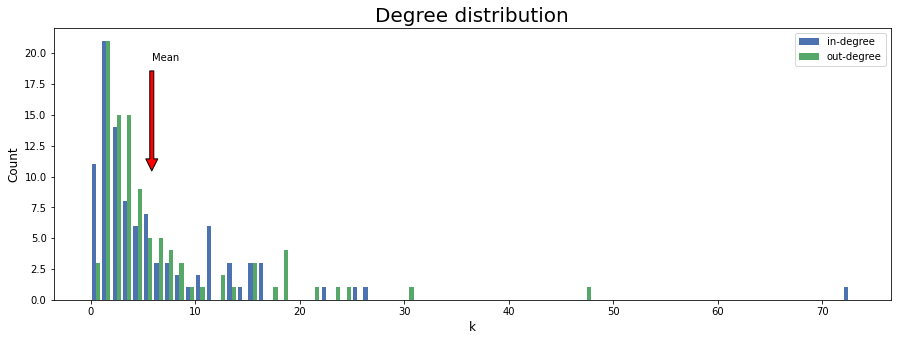

In [42]:
in_deg_list = np.array(list(d for n, d in dg.in_degree()))
out_deg_list = np.array(list(d for n, d in dg.out_degree()))

plt.style.use('seaborn-deep')
plt.figure(figsize=(15,5))
plt.annotate('Mean', xy=(in_deg_list.mean(), 10),  xycoords='data',
            xytext=(in_deg_list.mean(),20), textcoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05),
            verticalalignment='top')
# plt.annotate('Mean',(deg_in_list.mean(),10),xycoords='data')
plt.title('Degree distribution',fontsize=20)
hist = plt.hist([in_deg_list,out_deg_list],bins=max(in_deg_list),label=['in-degree','out-degree'])
plt.legend(loc='upper right')
plt.ylabel('Count',fontsize=12)
plt.xlabel('k',fontsize=12)
plt.show()

The degree distribution for both in and out degree resembles a power law distribution.

In [43]:
df_traits.groupby(['status']).agg({'appeared_in':['count','mean','min','max']})

appeared_in                  
               count      mean min max
status                                
Alive             66  7.439394   0  30
Deceased          32  3.812500   0  20

Unsurprisingly characters that are catagorised as being alive appear in more episodes on average.

<h3 style="color:#42362B;"><b> Creating visualisations</b></h3>

In [44]:
def create_full_graph(size_measure,dg,node_colors,pos):
    '''
    Visualises the full graph using graphsviz.
    The size of the nodes can be chosen to be based on betweenness-, closeness-, degree-, or eigenvector centrality or how many episodes the character appears in.
    
    Parameters
    ----------
    size_measure : str
        String with the centrality measure which should be used to determine node size
    dg: networkx.Graph
        the network graph which should be drawn
    node_colors: dict
        Dictionary with the colorcode for each character
    pos: dict
        Dictionary with the desired position of each node
    '''
    size_dict = {'degree':(5,60),'betweenness':(15,180),'closeness':(5,60),'eigenvector':(9,110),'number_of_episodes':(0.5,6)}
    
    dg_agr = nx.nx_agraph.to_agraph(dg)

    dg_agr.node_attr['style'] = 'filled'
    dg_agr.node_attr['shape'] = 'circle'
    dg_agr.node_attr['gradientangle'] = 135
    dg_agr.node_attr['fixedsize'] = True
    dg_agr.node_attr['fontname'] = 'helvetica-bold'
    dg_agr.node_attr['penwidth'] = 6

    dg_agr.edge_attr['fontsize'] = 11
    dg_agr.edge_attr['arrowsize'] = 2
    dg_agr.edge_attr['arrowhead'] = 'vee'
    dg_agr.edge_attr['penwidth'] = 2
    dg_agr.edge_attr['len'] = 5
    dg_agr.edge_attr['color'] = "#6c757d"

    dg_agr.graph_attr['outputorder'] = 'edgesfirst'
    dg_agr.graph_attr['K'] = 0.55
    dg_agr.graph_attr['start'] = 42
    dg_agr.graph_attr['ratio'] = 'fill'
    dg_agr.graph_attr['size'] = '40,40'
    dg_agr.graph_attr['nodesep'] = 2

    for i in dg_agr.nodes():
        n = dg_agr.get_node(i)
        n.attr['fillcolor'] = node_colors[n]
        if size_measure != 'number_of_episodes':
            n.attr['width'] = 1.5+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][0]
            n.attr['fontsize'] = 12+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][1]
        else:
            n.attr['width'] = 1.5+float(n.attr[size_measure])*size_dict[size_measure][0]
            n.attr['fontsize'] = 12+float(n.attr[size_measure])*size_dict[size_measure][1]
        n.attr['label'] = '<'+i.replace(' ','<br/>')+'>'
        n.attr['pos'] = pos[i]

    for i in dg_agr.edges():
        n = dg_agr.get_edge(i[0],i[1])
        n.attr['label'] = ''


    dg_agr.draw("{size_measure}.png".format(size_measure = size_measure),prog="fdp")

In [45]:
# dg_agr = create_full_graph('degree',episode_graph[29])
# temp_g = nx.nx_agraph.from_agraph(dg_agr)
# pos = nx.nx_agraph.graphviz_layout(temp_g, prog="fdp")
# for key,item in pos.items():
#     pos[key] = str(item[0]/100)+','+str(item[1]/100)+'!'
# with open('pos.json', 'w') as fp:
#     json.dump(pos, fp)

In [46]:
# create_full_graph('degree', dg, node_colors, pos)
# create_full_graph('betweenness', dg, node_colors, pos)
# create_full_graph('closeness', dg, node_colors, pos)
# create_full_graph('eigenvector', dg, node_colors, pos)
# create_full_graph('number_of_episodes', dg, node_colors, pos)

<h2 style="color:#42362B;"><b> Community Detection</b></h2>

We would like to find communities to see if they can give some meaningful inside into the data. We will be finding the communities using the Louvain algorithm.

The Louvain algorithm first finds small communities by optimizes modularity locally on all nodes, then all nodes in the communities found are grouped into nodes, so there is one node for each community creating a new network. New communities are then found by optimizing the modularity again in this new network, and so on. We then pick the iteration with the highest modularity, as the algorithm doesn't check all combination and uses a heuristic, this is not guaranteed to give the optimal communities based on modularity. Modularity is a measure of how dense the connections between nodes in a groupping is, it is high if the nodes are more densely connected than expected based on the full graph.

In [47]:
def create_partition(nw):
    '''
    Compute the partition of the graph nodes which maximises the modularity using the Louvain heuristices
    
    Parameters
    ----------
    nw : networkx.Graph
    '''
    partition = community.community_louvain.best_partition(nw,random_state=42)
    return partition

# Graph need to be undirected for the louvain algorithm
un_dg = dg.to_undirected()
# Remove Edward Roberts as he has no links
un_dg.remove_node('Edward Roberts')

partition = create_partition(un_dg)

print(f"The network has {(len(set(partition.values())))} communities.")

The network has 6 communities.


In [48]:
mod = community.community_louvain.modularity(partition, un_dg)
print("The modularity value is:","{:.3f}".format(mod))

The modularity value is: 0.317


The modularity is quite low indicating the grouping isn't very good.

In [49]:
'''
Display the names of each character together in their communities
'''
communities = pd.DataFrame.from_dict(partition,orient='index',columns=['community'])
df1_styler = communities[communities.community == 0].style.set_table_attributes("style='display:inline'")
df2_styler = communities[communities.community == 1].style.set_table_attributes("style='display:inline'")
df3_styler = communities[communities.community == 2].style.set_table_attributes("style='display:inline'")
df4_styler = communities[communities.community == 3].style.set_table_attributes("style='display:inline'")
df5_styler = communities[communities.community == 4].style.set_table_attributes("style='display:inline'")
df6_styler = communities[communities.community == 5].style.set_table_attributes("style='display:inline'")

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_()+df4_styler._repr_html_()+df5_styler._repr_html_()+df6_styler._repr_html_(), raw=True)

,community
Ada Thorne,0
Finn Shelby,0
John Shelby,0
Polly Gray,0
Karl Thorne,0
Martha Shelby,0
Arthur Shelby Sr.,0
Anna Gray,0
Michael Gray,0
Charles Shelby,0


Looking at some statistics of the communities.

The average community size is: 16.167


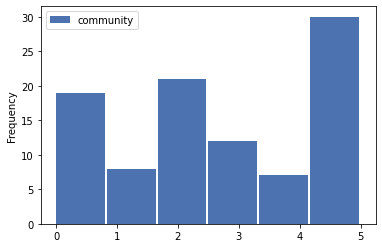

In [50]:
communities.plot.hist(by=community,bins=len(communities.community.unique()),width=0.8)
print('The average community size is: {:.3f}'.format(communities.value_counts().mean()))

In [51]:
df_traits = df_traits.join(communities)
# df_traits.to_pickle('traits.pkl')

In [52]:
df_traits.groupby('community').agg({'appeared_in':['count','mean','min','max'],
                                    'degree':['mean','min','max']})

appeared_in                       degree         
                count      mean min max       mean min  max
community                                                  
0.0                19  9.157895   0  30  21.473684   1   47
1.0                 8  7.625000   0  30  13.625000   2   49
2.0                21  5.904762   0  25   8.714286   1   23
3.0                12  4.250000   0  16   9.083333   2   30
4.0                 7  8.285714   0  20  10.142857   4   20
5.0                30  4.800000   1  30   8.933333   1  120

Community 0 tends to characters with higher than average degree.

In [53]:
df1_styler = df_traits.groupby(['community','enemies']).agg({'enemies':['count']}).style.set_table_attributes("style='display:inline'")
df2_styler = df_traits.groupby(['community','allies']).agg({'allies':['count']}).style.set_table_attributes("style='display:inline'")

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

enemies 
 
 
   
   
 count 
 
 
 community 
 enemies 
   
 
 
 
 
 0.0 
 False 
 18 
 
 
 True 
 1 
 
 
 1.0 
 False 
 6 
 
 
 True 
 2 
 
 
 2.0 
 False 
 14 
 
 
 True 
 7 
 
 
 3.0 
 False 
 6 
 
 
 True 
 6 
 
 
 4.0 
 False 
 7 
 
 
 5.0 
 False 
 16 
 
 
 True 
 14 
 
 
 

 
 
 
   
   
 allies 
 
 
   
   
 count 
 
 
 community 
 allies 
   
 
 
 
 
 0.0 
 False 
 18 
 
 
 True 
 1 
 
 
 1.0 
 False 
 5 
 
 
 True 
 3 
 
 
 2.0 
 False 
 10 
 
 
 True 
 11 
 
 
 3.0 
 False 
 10 
 
 
 True 
 2 
 
 
 4.0 
 False 
 5 
 
 
 True 
 2 
 
 
 5.0 
 False 
 22 
 
 
 True 
 8

Community 0 and 4 tends to have characters that are neither categorised as allies or enemies.
The other communities does not seem to have a connection to whether the characters are categorised as allies, enemies, or neither.

In [54]:
df_traits.groupby(['community','status']).agg({'appeared_in':['count','mean','min','max']})

appeared_in                   
                         count       mean min max
community status                                 
0.0       Alive             12  12.000000   0  30
          Deceased           7   4.285714   0  20
1.0       Alive              5   9.600000   0  30
          Deceased           3   4.333333   3   6
2.0       Alive             15   6.800000   0  25
          Deceased           6   3.666667   1  10
3.0       Alive              6   2.666667   0   5
          Deceased           6   5.833333   2  16
4.0       Alive              6   9.666667   0  20
          Deceased           1   0.000000   0   0
5.0       Alive             21   5.809524   1  30
          Deceased           9   2.444444   1  12

There doesn't seem to be a connection between community and whether the character is alive or dead.

<h3 style="color:#42362B;"><b> Creating visualisations</b></h3>

In [55]:
def create_community_graph(size_measure,dg,communities,pos):
    '''
    Visualises the full graph using graphsviz.
    The size of the nodes can be chosen to be based on betweenness-, closeness-, degree-, or eigenvector centrality or how many episodes the character appears in.
    Colors the nodes based on which community they belongs to.
    
    Parameters
    ----------
    size_measure : str
        String with the centrality measure which should be used to determine node size
    dg: networkx.Graph
        the network graph which should be drawn
    communities: pandas.DataFrame
        DataFrame with the information of which community each character belongs to
    pos: dict
        Dictionary with the desired position of each node
    '''
    size_dict = {'degree':(5,60),'betweenness':(15,180),'closeness':(5,60),'eigenvector':(9,110),'number_of_episodes':(0.5,6)}
    colors = {0:'#254450',
              1:'#28978a',
              2:'#83ac75',
              3:'#e7c05c',
              4:'#f39c55',
              5:'#e66545'}
    for name in dg.nodes():
        if name != 'Edward Roberts':
            node_colors[name] = colors[communities.loc[name]['community']]
    
    dg_agr = nx.nx_agraph.to_agraph(dg)

    dg_agr.node_attr['style'] = 'filled'
    dg_agr.node_attr['shape'] = 'circle'
    dg_agr.node_attr['gradientangle'] = 135
    dg_agr.node_attr['fixedsize'] = True
    dg_agr.node_attr['fontname'] = 'helvetica-bold'
    dg_agr.node_attr['penwidth'] = 6

    dg_agr.edge_attr['fontsize'] = 11
    dg_agr.edge_attr['arrowsize'] = 2
    dg_agr.edge_attr['arrowhead'] = 'vee'
    dg_agr.edge_attr['penwidth'] = 2
    dg_agr.edge_attr['len'] = 5
    dg_agr.edge_attr['color'] = "#6c757d"

    dg_agr.graph_attr['outputorder'] = 'edgesfirst'
    dg_agr.graph_attr['K'] = 0.55
    dg_agr.graph_attr['start'] = 42
    dg_agr.graph_attr['ratio'] = 'fill'
    dg_agr.graph_attr['size'] = '40,40'
    dg_agr.graph_attr['nodesep'] = 2

    for i in dg_agr.nodes():
        n = dg_agr.get_node(i)
        n.attr['fillcolor'] = node_colors[n]
        if size_measure != 'number_of_episodes':
            n.attr['width'] = 1.5+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][0]
            n.attr['fontsize'] = 12+float(n.attr['{}_centrality'.format(size_measure)])*size_dict[size_measure][1]
        else:
            n.attr['width'] = 1.5+float(n.attr[size_measure])*size_dict[size_measure][0]
            n.attr['fontsize'] = 12+float(n.attr[size_measure])*size_dict[size_measure][1]
        n.attr['label'] = '<'+i.replace(' ','<br/>')+'>'
        n.attr['pos'] = pos[i]

    for i in dg_agr.edges():
        n = dg_agr.get_edge(i[0],i[1])
        n.attr['label'] = ''


    dg_agr.draw("community_{}.png".format(size_measure),prog="fdp")

In [56]:
# create_community_graph('closeness',dg,communities,pos)
# create_community_graph('betweenness',dg,communities,pos)
# create_community_graph('degree',dg,communities,pos)
# create_community_graph('eigenvector',dg,communities,pos)
# create_community_graph('number_of_episodes',dg,communities,pos)

<h2 style="color:#42362B;"><b> Word Clouds - Character history</b></h2>

We though it would be interesting to see which words where used in characters "character history" section based on whether they were catagorised as allies or enemies and for the Shelby family. We did this by creating a word-cloud for each of the groups based on the TC-IDF score.

**TC-IDF**

TC-IDF is the term count (TC) multiplied by the inverse document frequency (IDF) for a term/word in a document in a corpus.

**TC**

Term count is found by simply counting the occurences of each term in the document.

**IDF**

The inverse document frequency for a term is found by taking the natural logarithm of the number of documents in the corpus ($N$) divided by the number of documents that the term appears in ($n_t$): $\text{idf}=\log\left(\frac{N}{n_t}\right)$ 

*References:*

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

**Word cloud**

A string with each term repeated based on its TC-IDF score is created, and the word-cloud is generated with the 100 most frequent term from this string. The size of the term is then determined by how many repetitions of the term there are in the string.

**Cleaning**

Before TC-IDF is calculated we clean the text. First we remove all links and section names from the text using regular expresions, we then remove punctuation.
As we are not interested in which names appear in the text of the groups, we remove all names. The text is then tokenized and all stopwords are removed. Lastly the text is lemmatized before being joined back together into one long string.

In [57]:
with open('character_history.json') as f:
    history = json.load(f)

In [58]:
def create_clean_tokens(history,characters):
    '''
    Creates a text files with text from the character history section.
    The text is clean removing all html notation, character names, stopwords, and punctuation.
    Text is then set to lowercase and tokenized and lemmatized before being joined back together and saved.
    
    Parameters
    ----------
    history : dict
        dictionary containing the text from the character history section of each character (from the get_character_history function)
    characters : list
        list of characters
    '''
    stop_words = set(stopwords.words('english'))
    character_tokens = {}
    for name in history.keys():
        full_text = ""
        for _,text in history[name].items():
            text=  re.sub(r'\[\[.*?\]\]', "", text)
            text=  re.sub(r'===.*?===', "", text)
            text=  re.sub(r'\n'," ", text)
            text=  re.sub(r'link=.*?\]\]',"", text)
            text=  re.sub(r'250px',"", text)
            text=  re.sub(r'=',"", text)
            
            #Remove punctuation
            for s in string.punctuation:
                text = text.replace(s,"")
            #Remove all names
            for character in characters:
                split_name = character.split(' ')
                for n in split_name:
                    text = re.sub(n,"",text)
            text= re.sub(r'Tommy',"",text) #Thomas Shelby is sometimes called Tommy
            text = re.sub(r'ralda',"",text) # There is a person called esme and on called esmeralda
            
                    
            #Set everything to lowercase
            text = text.lower()
            text = re.sub(r'mr',"",text)
            text = re.sub(r'mrs',"",text)
            text = re.sub(r'jr',"",text)
            
            full_text += text
            
        #Tokenize
        tokens = tokenizer.tokenize(full_text)
        #Remove stopwords
        tokens = [w for w in tokens if not w in stop_words]
        #Lemmatize
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        tokens = [w for w in tokens if len(w)!=1]
        
        with open('tokens/{}.txt'.format(name),'w') as f:
            f.write(' '.join(tokens))

In [59]:
create_clean_tokens(history,characters)

In [60]:
def create_corpus(df_traits):
    """ 
    Creates a corpus for the Shelbys, Enemies and Allies, from the tokenized text of each character 
    
    Parameters
    ----------
    df_traits : pandas.DataFrame
        dataframe with the information on each character
    """
    corpuses = {}
    groups = ['Shelbys', 'enemies', 'allies']
    for group in groups:
        if group == 'Shelbys':
            names = df_traits.loc['Thomas Shelby']['family'].copy()
            temp1 = df_traits.loc['Arthur Shelby']['family'].copy()
            temp2 = df_traits.loc['John Shelby']['family'].copy()
            names.extend(temp1)
            names.extend(temp2)
            names = list(set(names))
            
            file_list = ['{}.txt'.format(name) for name in names]
            corpuses[group] = PlaintextCorpusReader("tokens/",file_list)
            
        
            
        else:
            names = list(df_traits[df_traits[group] == True].index)
            file_list = ['{}.txt'.format(name) for name in names]
            corpuses[group] = PlaintextCorpusReader("tokens/",file_list)
    
        text = corpuses[group].raw()
        with open("group_text/{}.txt".format(group),'w') as f:
            f.write(text)
    corpus = PlaintextCorpusReader(root="",fileids =glob.glob('group_text/*.txt'))
    return corpus

In [61]:
def tc(corpus):
    """
    Calculates the term count for each word in each group
    
    Parameters
    ----------
    corpus : nltk.corpus
    """
    tc_dict = {}
    for group in corpus.fileids():
        text = nltk.Text(corpus.words(group))
        tc_dict[group[11:-4]] = dict(FreqDist(text))
    return tc_dict

def idf(corpus):
    """
    Calculates the IDF for each word in the corpus
    
    Parameters
    ----------
    corpus : nltk.corpus
    """
    text = TextCollection(corpus)
    idf_dict = {}
    for word in set(corpus.words()):
        idf_dict[word] = text.idf(word)
    return idf_dict

def tc_idf(corpus):
    """ 
    Calculates the TC-IDF for each word per group in the corpus, and returns it as a dictionary
    
    Parameters
    ----------
    corpus : nltk.corpus
    """
    tc_dict = tc(corpus)
    idf_dict = idf(corpus)
    tc_idf_dict = {}
    groups = list(tc_dict.keys())
    for group in groups:
        tc_idf_dict[group] = {}
        for key, value in tc_dict[group].items():
            tc_idf_dict[group][key] = value * idf_dict[key]
    return tc_idf_dict

def generate_wordcloud_string(corpus):
    """
    Creates the string for the wordcloud with each word repeated according to its TC-IDF score
    
    Parameters
    ----------
    corpus : nltk.corpus
    """
    tc_idf_dict = tc_idf(corpus)
    wordcloud_dict = {}
    groups = list(tc_idf_dict.keys())
    for group in groups:
        wordcloud_dict[group] = []
        for key, value in tc_idf_dict[group].items():
            wordcloud_dict[group].extend([key]*int(value))
        wordcloud_dict[group] = " ".join(wordcloud_dict[group]) 
    return wordcloud_dict

In [62]:
wordcloud_dict = generate_wordcloud_string(create_corpus(df_traits))

In [63]:
width = 1400
height = 2000

blues = cm.get_cmap('Blues')
blues = ListedColormap(blues(np.linspace(0,1,100))[30:])
orrd = cm.get_cmap('OrRd')
orrd = ListedColormap(orrd(np.linspace(0,1,100))[30:])
greens = cm.get_cmap('Greens')
greens = ListedColormap(greens(np.linspace(0,1,100))[30:])

wc_shelby = WordCloud(colormap = blues, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict['Shelbys'])

wc_enemy = WordCloud(colormap = orrd, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict['enemies'])

wc_ally = WordCloud(colormap = greens, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict['allies'])

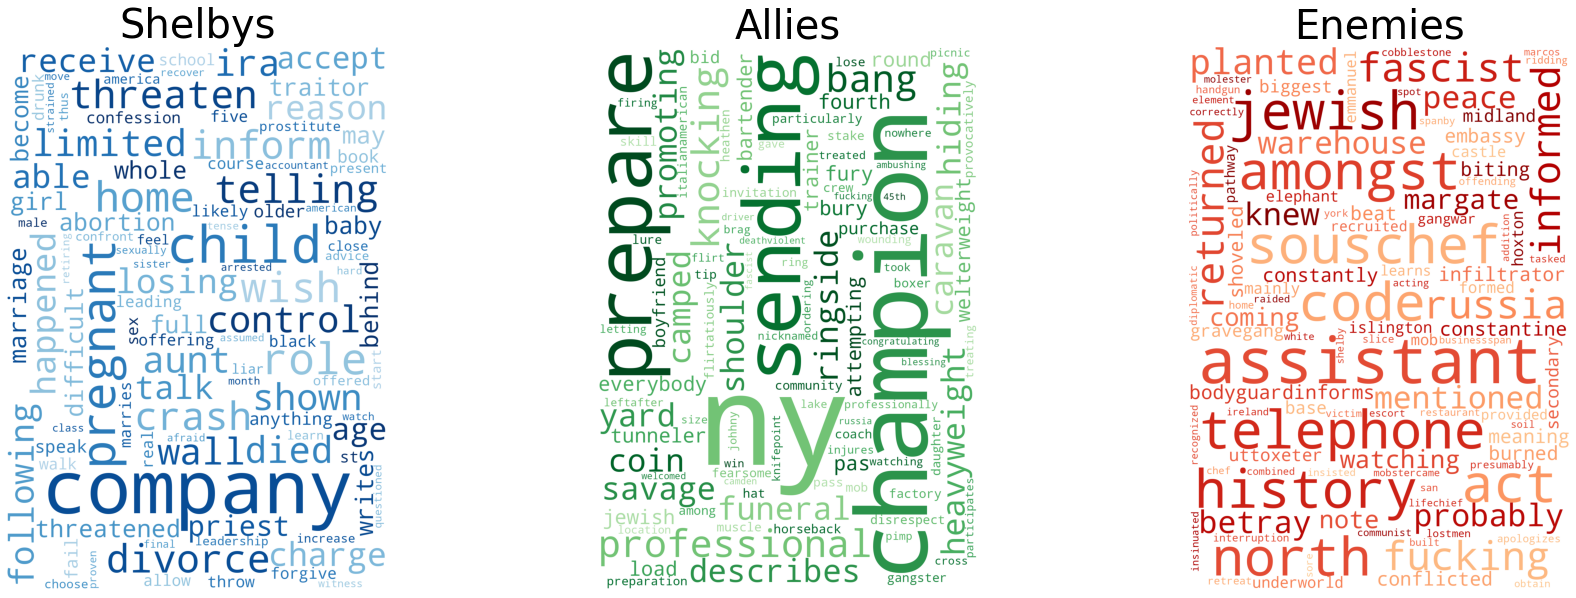

In [64]:
fig, axs = plt.subplots(1, 3,figsize=(30,10))
axs[0].imshow(wc_shelby)
axs[0].set_title('Shelbys',size=40)
axs[0].axis('off')
axs[1].imshow(wc_ally)
axs[1].set_title('Allies',size=40)
axs[1].axis('off')
axs[2].imshow(wc_enemy)
axs[2].set_title('Enemies',size=40)
axs[2].axis('off')
plt.show()

**Shelbys**

The character text of the Shelbys have a few different themes that pop out, family with words like child, pregnant, marriage, aunt, sister, and baby. The "legitimate" Shelby Company Limited with words like company, limited, accountant, wall st, and crash. And of course the gang activity of the peaky blinders with words like threaten, traitor, leadership, inform, confront, witness, liar, offered, and died.

**Allies**

A theme that stands out is boxing with champion, heavyweight, knocking, skill, round, trainer, and boxer. Another theme which is also apparent is crime with gangster, knifepoint, italian-american, mob, fearsome, and deathviolent. Caravan and horseback because of the gipsy allies they have.

**Enemies**

Some words that stand out are betray, molester, handgun, planted, infiltrator, underworld, gangwar. The russians, fascist, communist, and the jewish gang are all enemies at some point during the series. Generally it seems more violent than the two other word clouds.

<h2 style="color:#42362B;"><b> Text Analysis</b></h2>

<p style="color:#675544;"> Our idea were to analysis as much possible text to make comparision between the results</p>
<p style="color:#675544;">The tool we chose to use where Vander, we used a library with build in functions to help us for the sentiment to find the negative and positive polarity for each goal that we had. We chose as a tool for our sentiment analysis because VADER is a rule based approach, not only it is focus on the sentence but also VADER can shift the modularity on the combinations of the words, and have rules based on punctuation. In our case we are working with subtitles and text that are provided in the wiki fandom. This information is a combination of small to long sentences, with a complex structures, thats why Vader method are ideal for our dataset.</p>
<br>
<ul style="color:#675544;">
    <li>Sentiment Analysis for wiki text only the quotes section</li>
    <li>Sentiment Analysis for relashionship</li>
    <li>Sentiment Analysis for wiki text</li>
    <li>Sentiment Analysis for each episode per season with subtitles text</li>
<br>
<br></ul> 


<p style="color:#675544;">First of all, we need to load all the fils that we will work. All the files that e will use is json except the subtitles file that is txt ( we will talk about it in the next section)</p>

In [65]:
# Opening quotes file text
with open('quotes.json') as f:
    quotes = json.load(f)
    
# Opening relashionship file text
with open('relationships.json') as f:
    rel = json.load(f)
    
# Opening character file text    
with open('character_history.json') as f:
    history = json.load(f)


<br>
<p style="color:#675544;"> Loading all the paths of the subtitles file. We used here a regex to find them by the name of the episodes. Since the letters in the format of the each episode is in the format of e.g S04E06 meaning </p>
<br>
<ul style="color:#675544;">
    <li> s = season</li>
    <li> 04 = season number</li>
    <li> E = episode  </li>
    <li>06 = episode number</li>
</ul> 
<p style="color:#675544;">We use the [sS]\d\d[eE]\d\d regex where the [sS] and [eE] repserent the letters s and e, while th \d\d means the numbers. After that because we want to sort it after make them Uppercase as the episodes where begging with lower and upper cases. </p>


In [66]:
subs = {}
season_subs = {}
for i in open('subtitles.txt').readlines():
    file = i[:-1]
    name = re.findall('[sS]\d\d[eE]\d\d', file)[0].upper()
    subs[name] = open(file).read()  


<br>
<p style="color:#675544;"><b> Formats of the files </b> </p>
<ul style="color:#675544;">
    <li>Quotes: The json where structured "Name": ["Quote 1", "Quote 2" , ... "Quote n" ], " Name 2" : ["Quote 1", "Quote 2" , ... "Quote n" ], </li>
    <br>
    <li>Relationships:  The json structur is "Name A": {"Name of character 1 ":" Description of there relashionship", "Name of character 2 ":" Description of there relashionship", ...}, "NameB ": {"Name of character 1 ":" Description of there relashionship", "Name of character 2 ":" Description of there relashionship", ...} </li>
    <br>
    <li>Relationships:  The json structur is "Name A": {"Name of character 1 ":" Description of there relashionship", "Name of character 2 ":" Description of there relashionship", ...}, "NameB ": {"Name of character 1 ":" Description of there relashionship", "Name of character 2 ":" Description of there relashionship", ...} </li>
    <br>
    <li> History of Character:  The json structur is "Name A": {"Background":" Description of characters background", "Series1":" Description of the character through series",..."Series n":" Description of the character through series" ...}  </li>
    <br>
     <li> Subtitles:  We had for each episode a txt file and is structured "line1 \n line2 \n ... \n  </li>
    </ul>
<br>    
<p style="color:#675544;"> Of course the text had some unecessary symbols. That's we needed to clean them first before using them. We achived that by using general regular expressions <p style="color:#675544;"> 

<ul style="color:#675544;">
    <li> \ [ \ [ . * ? \ ] \ ] this is used to clean from links, so we removed them</li>
    <li>'===.*?===' we had text format from the wiki page that represed classifications in the wiki text, so we removed it.</li>
    <li>\n'," " insted of a new add space </li>
    <li>[.!?-]+ *'. split the text according to the format our json file is</li>
</ul> 
<br> 

In [67]:
#Function that removed unecessary symbolys for files and returns a split sentences.

def text_sent(text):
    text=  re.sub(r'\[\[.*?\]\]', "", text)
    text=  re.sub(r'===.*?===', "", text)
    text=  re.sub(r'\n'," ", text)
    return re.split(r'[.!?-]+ *',text)

<br><p style="color:#675544;">Here are the functions that we will reuse to calculate the sentiment analysis for all the files.We use SentimentIntensityAnalyzer library to help us to calculate the polarity and provide us with the sentiment score for sentence, with the help of sentiment_score_VADER function. Then we calculate the average score fro all the sentences with stentiment_avg(sentences) function </p>

In [68]:
# function to print sentiments
sid_obj = SentimentIntensityAnalyzer()

# function returns the sentiment score for one sentnce
def sentiment_score_VADER(sentence):
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

# function returns the average of sentiment of sentences
def stentiment_avg(sentences):
    scores = [sentiment_score_VADER(i) for i in sentences if len(i)>0]
    return sum(scores)/len(scores) if len(scores)!=0 else 0

<br>
<p style="color:#675544;"><b>Sentiment Analysis for wiki text only the quotes section</b></p>
<br>
<p style="color:#675544;">Quotes is an interesting topic that could be analysed, as it is quite popular to use quotes in our life for inspiration. How about to analyse the polarity of the quote? Are the quotes that Peaky Blinders characters use are positive or negative? </p>
<br>
<p style="color:#675544;">All we need to find out about the tone of Quotes is to clear our data and then apply sentimente analysis tool, Vader, as we mention previously.</p>
<br>

In [69]:
# Creating a dictionary while spliting the text file and cleaning the text file with regex.

sentenceDic = {}
for name in quotes:
        sentenceDic[name] = []
        for line in quotes[name]:
            sentence = re.split(r'[.!?-]+ *',line)
            sentenceDic[name].extend(sentence)

In [70]:
# function returns a dictionary sentiment polarity and name by calling the stentiment_avg()
def quotesSentimentVader():
    return {name: stentiment_avg(sentenceDic[name]) for name in sentenceDic}

In [71]:
# Save the data of quotesSentimentVader function into a dictionary quotes_sentiment
quotes_sentiment = quotesSentimentVader()

# Printing the top five of the positive tone quotes, 
# Sorting by the polarity and printing it in a presentable format

print( '\n Top 10 characters with the a negative quotes tones: ')
pd.DataFrame.from_dict(quotes_sentiment,orient='index',columns=['Polarity']).sort_values(by='Polarity',ascending=True).head(10)



 Top 10 characters with the a negative quotes tones: 


,Polarity
Bonnie Gold,-0.283600
Oswald Mosley,-0.266122
Alfie Solomons,-0.263562
Tatiana Petrovna,-0.252250
Jessie Eden,-0.227833
Darby Sabini,-0.212560
Johnny Dogs,-0.199667
Niall Devlin,-0.164633
Luca Changretta,-0.146670
Sergeant Moss,-0.113333


In [72]:
# Printing the top five of the positive tone quotes, 
# reversing the dictionary to show from the greater number to smaller.
# Sorting by the polarity and printing it in a presentable format

print('\n Top 10 characters with the a positive quotes tones :')
pd.DataFrame.from_dict(quotes_sentiment,orient='index',columns=['Polarity']).sort_values(by='Polarity',ascending=False).head(10)


 Top 10 characters with the a positive quotes tones :


,Polarity
Donal Henry,0.246950
Inspector Campbell,0.216400
Danny Whizz-Bang,0.197133
Jeremiah Jesus,0.188567
Michael Gray,0.123386
John Shelby,0.088780
Aberama Gold,0.086700
Finn Shelby,0.064000
Curly,0.053700
Ada Thorne,0.035900


<p style="color:#675544;"><b>Plot all the Characters and the tone of Quotes</b></p>
<br><p style="color:#675544;">Let's create a plot to see the total tone of all the characters that actually have quotes. We can observe that the negative quotes tone are much higher rather than the positive ones.( Not taking into account ones that were neutral, we removed them from the plot ). What we were expecting, at the end it is a gangster series :P </p>

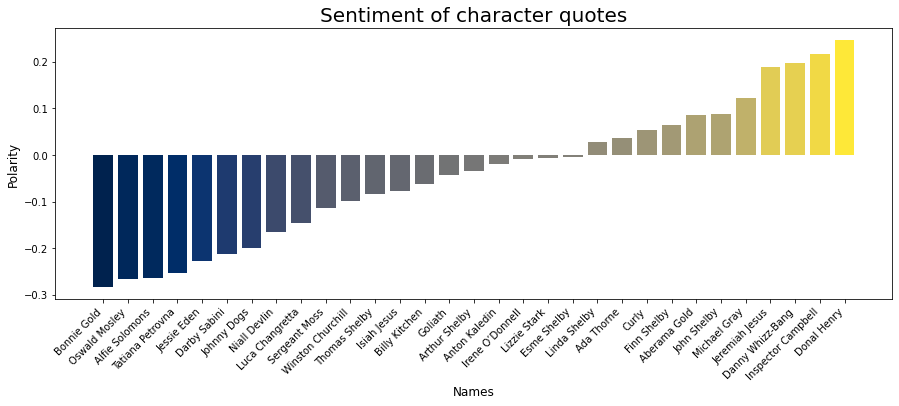

In [114]:
# Presentation in a graph From the most negative to the most positive according to the data.

keys = [i for i,k in sorted(quotes_sentiment.items(), key= lambda a: a[1])if k != 0]
values = [k for i,k in sorted(quotes_sentiment.items(), key= lambda a: a[1])if k != 0]

cmap = plt.get_cmap("cividis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(15,5))
plt.title('Sentiment of character quotes',fontsize=20)
plt.bar(keys,values, color=cmap(rescale(values)))
plt.xticks(rotation=45,ha='right')
plt.ylabel('Polarity',fontsize=12)
plt.xlabel('Names',fontsize=12)
plt.show()

<br> <p style="color:#675544;"><b>Sentiment Analysis for all the wiki page of the characters</b></p><br>
<p style="color:#675544;">How about now to check the tone of TOP 10 Character not just by the Quotes but through whole wiki page. Then we can compare the results, if the ones with negative quotes has a negative overall wiki page, same for the positives as well. </p>
<p style="color:#675544;">The steps are similar we call the all ready existings functions. </p>

In [74]:
# function that returns a dictionary of name and polarity of sentences 

def historySentimentVader():
#     return {name: stentiment_avg(text_sent(" ".join(history[name].values()))) for name in history if 'Background' in history[name] }
    return {name: stentiment_avg(text_sent(" ".join(history[name].values()))) for name in history }


In [75]:
# Save the data of historysentimentVader function into a dictionary history_sentiment

history_sentiment = historySentimentVader()

# Printing the top five of the positive tone quotes, 
# Sorting by the polarity and printing it in a presentable format

print('\n Top 10 characters with the a negative wiki text analysis: ')

pd.DataFrame.from_dict(history_sentiment,orient='index',columns=['Polarity']).sort_values(by='Polarity',ascending=True).head(10)



 Top 10 characters with the a negative wiki text analysis: 


,Polarity
Curly,-0.374667
Jimmy McCavern,-0.349980
Gina Gray,-0.344836
Jeremiah Jesus,-0.331675
Danny Whizz-Bang,-0.324194
Father Hughes,-0.317900
Billy Kitchen,-0.272600
Alfie Solomons,-0.262671
Finn Shelby,-0.260144
Arthur Shelby,-0.242178


In [76]:
# Printing the top five of the positive tone quotes, 
# reversing the dictionary to show from the greater number to smaller.
# Sorting by the polarity and printing it in a presentable format

print('\n Top 10 characters with the a positive wiki text analysis: ')
pd.DataFrame.from_dict(history_sentiment,orient='index',columns=['Polarity']).sort_values(by='Polarity',ascending=False).head(10)



 Top 10 characters with the a positive wiki text analysis: 


,Polarity
Ruby Shelby,0.285950
Charles Shelby,0.273460
Ben Younger,0.238350
Harry Fenton,0.231517
Clive Macmillan,0.210871
Grace Shelby,0.107597
Luca Changretta,0.104900
Ollie,0.097486
May Carleton,0.083213
Winston Churchill,0.082150


<p style="color:#675544;"> <b>The results are pretty interesting!</b> We can see that the ones with the most positive Quotes are not that "good" in the description on the whole wiki page. </p>
<br>
<p style="color:#675544;"> <b>Jeremiah Jesus</b> is one of the toppest on the list with the positive tone, with 0.18, Quotes but in the wiki page is 4th for the most negative tone with -0.33 polarity. </p>
<br>
<p style="color:#675544;"> Same for <b>Curly</b> is 9th on the list with the positive tone, with 0.07, Quotes but in the wiki page is 1st for the most negative tone with -0.37 polarity. </p>
<br>
<p style="color:#675544;"> Although <b>Alfie Solomons</b> is in the both negative list tones, with -0.26 polarity</p>
<br>
<p style="color:#675544;"> <b>Ruby Shelby</b> and <b>Charles Shelby</b> is in top in the list of positive for their wiki page, but they are not displayed in the quote section. Probably because they are kids</p>
<br>
<p style="color:#675544;"> <b>Donal Henry</b> and <b>Inspector Campbell</b> is in top in the list of positive for their quotes, but they are not displayed in the wiki page positive tone neither in the negative, probably because they have more neutral tone</p>

<p style="color:#675544;"><b>Overall Outcome</b></p>
<p style="color:#675544;">The results showed us, not always the tone of the quote represents the overall tone of the character. "Bad people" have positive quotes as well.</p><br>
<p style="color:#675544;"> So let's check an example of Jeremiah Jesus quote, "God says he don’t mess with Small Heath" as we observe it has an overall positive outcome but in his wiki page description "History before his involvement with the Peaky Blinders. He fought in the war alongside Thomas Shelby, but vowed never to pick up a weapon again after the end of the war.." and " While he promised never to pick up a gun again after the war, Tommy asks Jeremiah to pick up a weapon and defend Small Heath once again, to which he agrees." we can see this why he got the negative result, he has words that includes war, fought and weapon, agrees to defend.</p>


<p style="color:#675544;"><b>Plot all the Characters and the tone of wiki page</b></p><br>
<p style="color:#675544;">Again we can notice that the overall tone of the most characters through the wiki page are negative.( Not taking into account ones that were neutral, we removed them from the plot )</p>

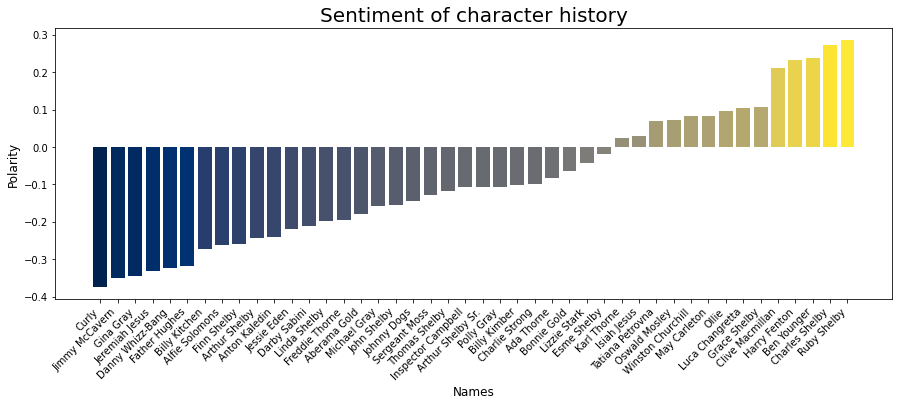

In [113]:
# Presentation in a graph From the most begative to the most positive according to the data.

keys = [i for i,k in sorted(history_sentiment.items(), key= lambda a: a[1])if k != 0]
values = [k for i,k in sorted(history_sentiment.items(), key= lambda a: a[1])if k != 0]


plt.figure(figsize=(15,5))
plt.title('Sentiment of character history',fontsize=20)
plt.bar(keys,values, color=cmap(rescale(values)))
plt.xticks(rotation=45,ha='right')
plt.ylabel('Polarity',fontsize=12)
plt.xlabel('Names',fontsize=12)
plt.show()

<br> <p style="color:#675544;"><b>Sentiment Analysis for the relashionship of characters from wiki page</b></p><br>
<br>
<p style="color:#675544;">Another way to use sentimente analysis in a fun way is by observing the relashionships between the characters. Are the Shelby Family in a good relashionship between them?  </p>
<p style="color:#675544;">The source we used is mention above and we call the previous created functions again.</p>
<br>

In [78]:
# function that returns a dictionary with a combination of names and polarity of sentences
# that discribes their relationship 

def relashionshipsSentimentVader():
    return {name: {target: stentiment_avg(text_sent(rel[name][target])) for target in rel[name] } for name in rel}

In [79]:
# code that prints a dictionary of polarity of relashionship sentences and the pair of names

rel_sentiment = relashionshipsSentimentVader()

l = []
for i,k in rel_sentiment.items():
    for a,b in k.items():
        l.append((b,i,a))

for i in sorted(l):
    print("{:+.3f} {} - {}".format(i[0],i[1],i[2]))
       

-0.325 John Shelby - Arthur Shelby
-0.299 Freddie Thorne - Thomas Shelby
-0.299 John Shelby - Polly Gray
-0.274 Lizzie Stark - Thomas Shelby
-0.242 Thomas Shelby - Lizzie Stark
-0.229 Arthur Shelby - Finn Shelby
-0.211 Esme Shelby - Thomas Shelby
-0.140 May Carleton - Thomas Shelby
-0.132 Michael Gray - Polly Gray
-0.128 Winston Churchill - Thomas Shelby
-0.115 Inspector Campbell - Polly Gray
-0.112 Aberama Gold - Polly Gray
-0.100 Inspector Campbell - Thomas Shelby
-0.095 Arthur Shelby - Thomas Shelby
-0.091 John Shelby - Michael Gray
-0.087 Finn Shelby - Arthur Shelby
-0.085 John Shelby - Esme Shelby
-0.082 Michael Gray - John Shelby
-0.079 Lizzie Stark - Arthur Shelby
-0.068 Father Hughes - Thomas Shelby
-0.032 Thomas Shelby - Arthur Shelby
-0.019 Luca Changretta - Audrey Changretta
-0.008 Ada Thorne - Thomas Shelby
-0.005 Thomas Shelby - Polly Gray
-0.002 Arthur Shelby - Michael Gray
+0.000 Charlotte Murray - Michael Gray
+0.000 Luca Changretta - Alfie Solomons
+0.000 Luca Changret

<p style="color:#675544;"><b>Overall Outcome</b></p>

<p style="color:#675544;">Let's start we Thomas Shelby the main charachter, we can easly say that Thomas has more positive relashionships between his relatives with the highest <b>+0.494 Tatiana Petrovna </b>, his lover and secondly with his wife <b>+0.415 Grace Shelby </b>. On the other hand, he most negative relationship status is with <b> -0.274 Lizzie Stark </b> his brothers wife and with<b> -0.211 Esme Shelby </b>another of his brothers wife. We can say he are struggling to have good relashionship with his brothers wife's.</p><br>

<p style="color:#675544;">For Arthur's Shelby ( my favorite character ) relashionship results, we can easly say he has more positive relashionships between <b>+0.478 Grace Shelby </b>, Thoma's wife, and <b> +0.329 Linda Shelby</b> his  ex wife. He has negative relationship status is with <b> -0.229 Finn Shelby</b>, his brother, and with<b> -0.325 John Shelby</b> his younger brother.</p><br>

<p style="color:#675544;">For Polly's Gray relashionship results, we can easly say she has more positive relashionship only with one person <b>+0.021 Ruben Oliver </b>,her lover. The rest results are negative. 
 <br>

<p style="color:#675544;">For John's Shelby relashionship results, we can easly say he has most positive relashionshinp with his wife <b>+0.225 Lizzie Stark</b>r. Althought  Lizzie Stark has less positive results to her husband with a number of +0.155 between them.
 <br>

<p style="color:#675544;">For Finn's Shelby relashionship results, we can easly say he has most positive relashionshinp with his brother  <b>+0.300 Thomas Shelby</b>
 <br>

<br> <p style="color:#675544;"><b>Sentiment Analysis for all the subtitles per episode per season from an external source total 30 hours of subtitles</b></p>
<br>
<p style="color:#675544;">Last part that we thought it would be good idea to observe were the sentimente analysis of all the epiodes. It would be interesting to see which episodes had a negative tone and which ones had the most positive tone.</p>
<p style="color:#675544;">The steps are similar we call the all ready existings functions. </p>

In [80]:
# function that returns a dictionary of episobe name and polarity of subtitles 

def subtitlesSentimentVader():
    return {name: stentiment_avg(text_sent(subs[name])) for name in subs}

In [81]:
# code that prints a dictionary of episobe name and polarity of subtitles 

sub_sentiment = subtitlesSentimentVader()

for i,k in sorted(sub_sentiment.items()):
    print(i,'\t',k)

S01E01 	 -0.0029102222222222207
S01E02 	 0.01361483870967742
S01E03 	 0.020896816208393634
S01E04 	 0.04035377008652661
S01E05 	 0.02063529411764707
S01E06 	 0.02614610951008646
S02E01 	 0.008039811912225716
S02E02 	 0.018475372124492552
S02E03 	 0.02965153172866524
S02E04 	 0.03747793017456358
S02E05 	 0.040733036848792877
S02E06 	 0.02012619354838709
S03E01 	 0.027233657858136313
S03E02 	 0.02987341463414634
S03E03 	 0.02043434610303829
S03E04 	 0.00048057210965434937
S03E05 	 0.053464689265536616
S03E06 	 0.016291246684350103
S04E01 	 0.02233922872340426
S04E02 	 0.021066174298375182
S04E03 	 0.01926295264623955
S04E04 	 0.012693495934959362
S04E05 	 0.03422035928143715
S04E06 	 0.005934069981583795
S05E01 	 0.025922483660130714
S05E02 	 0.02998493827160491
S05E03 	 0.015148567530695772
S05E04 	 0.01198122332859175
S05E05 	 0.030416391184572972
S05E06 	 -0.0016592148309705664


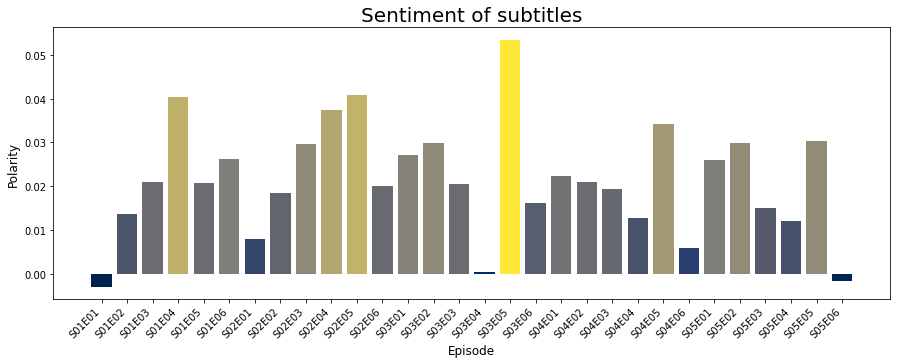

In [112]:
# for seasons paragraph
keys = [i for i,k in sorted(sub_sentiment.items())]
values = [k for i,k in sorted(sub_sentiment.items())]

plt.figure(figsize=(15,5))
plt.title('Sentiment of subtitles',fontsize=20)
plt.bar(keys,values, color=cmap(rescale(values)))
plt.xticks(rotation=45,ha='right')
plt.ylabel('Polarity',fontsize=12)
plt.xlabel('Episode',fontsize=12)
plt.show()

<p style="color:#675544;"><b>Overall Outcome</b></p>
<p style="color:#675544;">The results showed us, that the most seasons had poritive tone, but this could be disguised because the sentimente analysis scores had numbers between -0.002 to 0.05, extremelly close to neutral.</p><br>

<p style="color:#675544;"> The most positive episode was from the season 3 the episode 5. Looking in the descriprion of the episode lot of positive things happening for example,Thomas Shelby is coming back from hospital to his home, Ada sister of Shelby's are joining her brother to their Business, Thomas spending good time with Tatiana petrova. </p>

<p style="color:#675544;"> The most negative episode was from the season 1 the episode 1. Looking in the descriprion of the episode negative opening is happeng for example Arthur Shelby gets captured by policemen, The two Italians that had witnessed Danny Whizz-Bang murdering a waiter in Little Italy watch with satisfaction as Thomas kills Danny, Polly asks Thomas if he got rid of the guns, and Thomas lies and tells her that he did. The plot of the opening episode has a lot of guns, killing, police involvement, this is happening because the serie as needed to introduce and show the background of each charater, most of them are not that positive.</p>

<h2 style="color:#42362B;"><b> Word Clouds - Subtitles</b></h2>

<p style="color:#675544;"> We thought that it will be interesting to add wordclouds per each season based on the subtitles that we found. Just to see if someone could guess( spoilers ) what the season is talking about. Moreover we would like to compare each season between them. </p>
<p style="color:#675544;"> We reused the perivious function that where created above for word clouds, we created a new table with all the subtitels per season</p>
<br>

In [83]:
# Created a list of seasons text files
season_subs = [
"subtitles_text/peaky.blinders.s01.lower.txt",
"subtitles_text/peaky.blinders.s02.lower.txt",
"subtitles_text/peaky.blinders.s03.lower.txt",
"subtitles_text/peaky.blinders.s04.lower.txt",
"subtitles_text/peaky.blinders.s05.lower.txt",
]


In [84]:
#We reused the perivious function that where created above for word clouds
width = 1400
height = 2000

# Created corpus function 
corpus = PlaintextCorpusReader(".", season_subs)
# Generate word clouds
wordcloud_dict = generate_wordcloud_string(corpus)



In [85]:
# Created a random color picker list to make it fancy.

def colorpicker():
    
    color_list = []

    blues = cm.get_cmap('Blues')
    blues = ListedColormap(blues(np.linspace(0,1,100))[30:])
    orrd = cm.get_cmap('OrRd')
    orrd = ListedColormap(orrd(np.linspace(0,1,100))[30:])
    greens = cm.get_cmap('Greens')
    greens = ListedColormap(greens(np.linspace(0,1,100))[30:])
    
    color_list.append(blues)
    color_list.append(orrd)
    color_list.append(greens)
    
    return color_list

<p style="color:#675544;"> <b>Displaying the wordclouds </b></p>

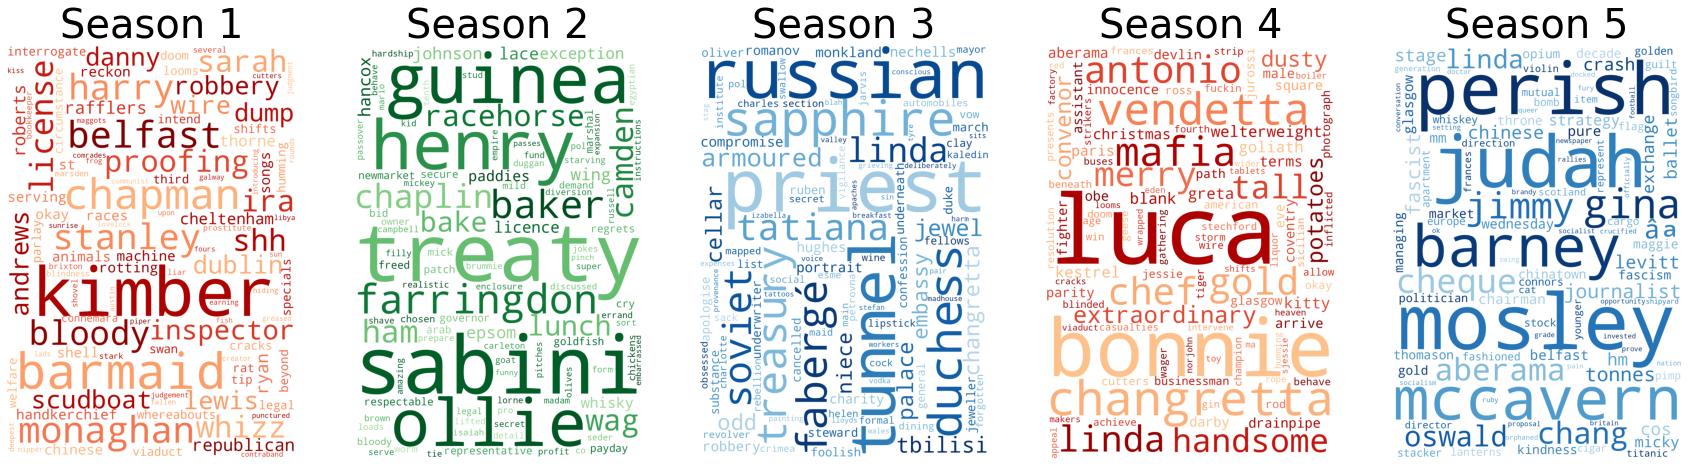

In [115]:
# Presenting the world cloud of the seasons. Using the same function as before and modify this section to be 
# fullfill the needs of the previous functions.
import random

index = 0
fig, axs = plt.subplots(1, 5,figsize=(30,10))

for i in season_subs :
    wc = WordCloud(colormap = random.choice(colorpicker()), max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict[i[11:-4]])
    
    axs[index].imshow(wc)
    axs[index].set_title("Season " + str(index+1),size=40)
    axs[index].axis('off')
    index+=1
    
plt.show()


<p style="color:#675544;"><b>Overall Outcome</b></p>

<br>

<ul style="color:#675544;">
    <li>Season 1: Inspector Campbell from Belfast, Ireland, is the main antagonist of the season. Billy Kimber secondary antagonist of the season.
        The Peaky Blinders have gotten their hands on a crate of machine guns, the IRA is interested in buying them.
        Grace Burgess is send to spy on Thomas Shelby by Inspector Campbell as a barmaid in the bar the Peaky Blinders own.</li>
    <br>
    <li>Season 2: Inspector Campbell is the main and Darby Sabini the secondary antagonist of the season.
        The Peaky Blinders plans to take over the horse racing business, but needs a licence to be able to have bookies. </li>
    <br>
    <li>Season 3: The Russians aristocrats does business with Thomas Shelby but plans to kill him after they get what they want. Father Hughes (priest) is the main antagonist of the season. </li>
    <br>
    <li>Season 4: Luca Changretta the main antagonist of the season is a New York mob boss, who is planing on killing the Shelbys and taking over their business.
        Aberama Gold, a hit-man, is hired by Thomas Shelby when Luca Changretta comes to England. In return Aberama wants Thomas to help his son Bonnie Gold become a boxing champion.  </li>
    <br>
     <li>Season 5: Oswald Mosely is an MP, a Minister, and adviser to the Prime Minister he serves as the main antagonist of the season.
         Jimmy McCavern, Michael and Gina Gray serves as the secondary antagonists of the season.
         Thomas Shelby has become an MP for south Birmingham.
         McCavern kills Aberama Gold's son Bonnie to send a message to the Shelby family.
         Mosley is the leader of the political party: the British Union of Fascists and plans on starting a revolution.
         This becomes known to Winston Churchill, who tells Thomas Shelby to do whatever possible to stop the revolution.</li>
    </ul>
<br>    
<br> 

<img src="https://cdn.pixabay.com/photo/2018/02/19/20/28/abstract-3166168__340.png" alt="devider" style=" width: 50%;" >

<h1 style="color:#42362B;"><b> Part4: Discussion. Think critically about your creation </b></h1>


The analysis of top characters for each season according to the centrality measures, could be improved by removing the characters when they are last seen in the show, instead of only updating an attribute and showing it in the visualisation of the graph. This way dead characters wouldn't occupy the top spots in seasons they don't appear in, and we would most likely see more relevant top characters.

For the community detection the Louvain algorithm is probably not the best option as modularity has difficulties detecting small communities, and we would expect to have multiple small communities for the different gangs. We didn't really get any inside from the communities we found. However, we did not do any text analysis using the communities so we can't for sure say they have no inside to offer.

We didn't end up using the allegiance for anything other than the visualisation, it could probably be interesting to do some text analysis on the characters grouped by their allegiance.

We could also have done sentiment analysis on the different subsections of the character history, to see if there is a change over the seasons.

<img src="https://cdn.pixabay.com/photo/2018/02/19/20/28/abstract-3166168__340.png" alt="devider" style=" width: 50%;" >

<h1 style="color:#42362B;"><b>Part 5: Contributions.</b></h1>
<br> 
<p style="color:#42362B;"> <b>Who did what?
You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).</b></p>

| Section                         | Main Responsible |
|---------------------------------|------------------|
| Data acquisition                | Rasmus           |
| Evolving Network                | Rasmus           |
| Full Network                    | Rasmus           |
| Community Detection             | Rasmus           |
| Word Clouds - Character history | Rasmus           |
| Text Analysis                   | Anastasia        |
| Word Clouds - Subtitles         | Anastasia        |
| Website                         | Anastasia        |

<img src="https://i.pinimg.com/originals/b0/bd/ca/b0bdcac479149dfc777e37f26f959a57.png" alt="By Order of Peaky Blinders" style="background-size: cover;background-repeat: no-repeat; background-position: 50% 50%; width: 100%;" >